In [149]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from camel_tools.utils.dediac import dediac_ar
import seaborn as sns

# تحميل الملف
file_path = r"C:\Users\Batoo\Downloads\الغزوات - Sheet1 (1).csv"
df = pd.read_csv(file_path)

# عرض الأعمدة المهمة
df = df[['الاسم', 'القصة', 'أسبابها']].dropna()

In [151]:
# دمج الأعمدة معًا (القصة + الأسباب)
df['النص'] = df['القصة'] + ' ' + df['أسبابها']

# إزالة التشكيل من النصوص
df['النص'] = df['النص'].apply(lambda x: dediac_ar(str(x)))

# طباعة مثال
print(df['النص'].iloc[0])

في شهر صفر من السنة الثانية للهجرة، خرج رسول الله ﷺ بنفسه في أولى غزواته، وكان معه سبعون رجلا من المهاجرين. وقد استخلف النبي ﷺ على المدينة سعد بن عبادة رضي الله عنه، ثم توجه النبي ﷺ بالجيش ليعترض قافلة لقريش كانت تمر بتلك المناطق. وصل الجيش إلى منطقة ودان (وتسمى أيضا الأبواء)، ولكنهم لم يلقوا قافلة ولا حدث قتال. وفي هذه الغزوة، عقد رسول الله ﷺ معاهدة أمن وسلم مع بني ضمرة، وكان سيدهم يدعى عمرو بن مخشي الضمري. وقد نصت المعاهدة على: أن يكون بين المسلمين وبني ضمرة أمن وسلم. وأن لا يناصروا أعداء النبي ﷺ. وإذا احتاج النبي ﷺ إلى نصرتهم، فإنهم ينصرونه. وكان لواء الغزوة أبيض، وقد حمله حمزة بن عبد المطلب رضي الله عنه. ودامت الغزوة خمسة عشر يوما، ثم رجع رسول الله ﷺ ومن معه إلى المدينة. أراد الرسول ﷺ اعتراض قافلة لقريش تمر من قرية ودان


In [153]:
from sklearn.feature_extraction.text import CountVectorizer

custom_stopwords = [
    # أدوات ربط وظروف
    "من", "على", "إلى", "عن", "أن", "إن", "في", "ثم", "مع", "وقد", "حتى",
    "و", "ف", "كان", "وكان", "ذلك", "هذه", "هذا", "هذي", "ه", "هو", "هي",
    "لم", "لن", "ما", "لا", "كل", "قد", "أو", "بل", "بين", "نحو", "إذ", "إذا","بعد","وفي",

    # كلمات دينية عامة
    "الله", "الرسول", "النبي", "صلى", "عليه", "وسلم", "رضي", "عن", "عنه", "عنها", "عنهم", "ﷺ",

    # كلمات من سياق الغزوات
    "غزوة", "غزوه", "معركة", "معركه", "جيش", "المسلمين", "الاسلام", "الدوله", "الاسلاميه",
    "الفتح", "فتح", "الخطاب", "الخليفه", "قريش", "الروم", "الفرس", "الساسانيه", "البيزنطي",
    "الشام", "العراق", "المدينه", "يحدث",

    # أسماء مكررة
    "ابو", "ابي", "بن", "بني", "عمر", "علي", "خالد", "الوليد"
]



vectorizer = CountVectorizer(
    stop_words=custom_stopwords,
    max_features=30,
    token_pattern=r'\b[^\d\W]+\b'  # فقط كلمات عربية بدون أرقام أو رموز
)


# تطبيق التحليل
X_counts = vectorizer.fit_transform(df['النص'])
word_freq = X_counts.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

# إنشاء DataFrame للكلمات
freq_df = pd.DataFrame({'الكلمة': words, 'التكرار': word_freq}).sort_values(by='التكرار', ascending=False)

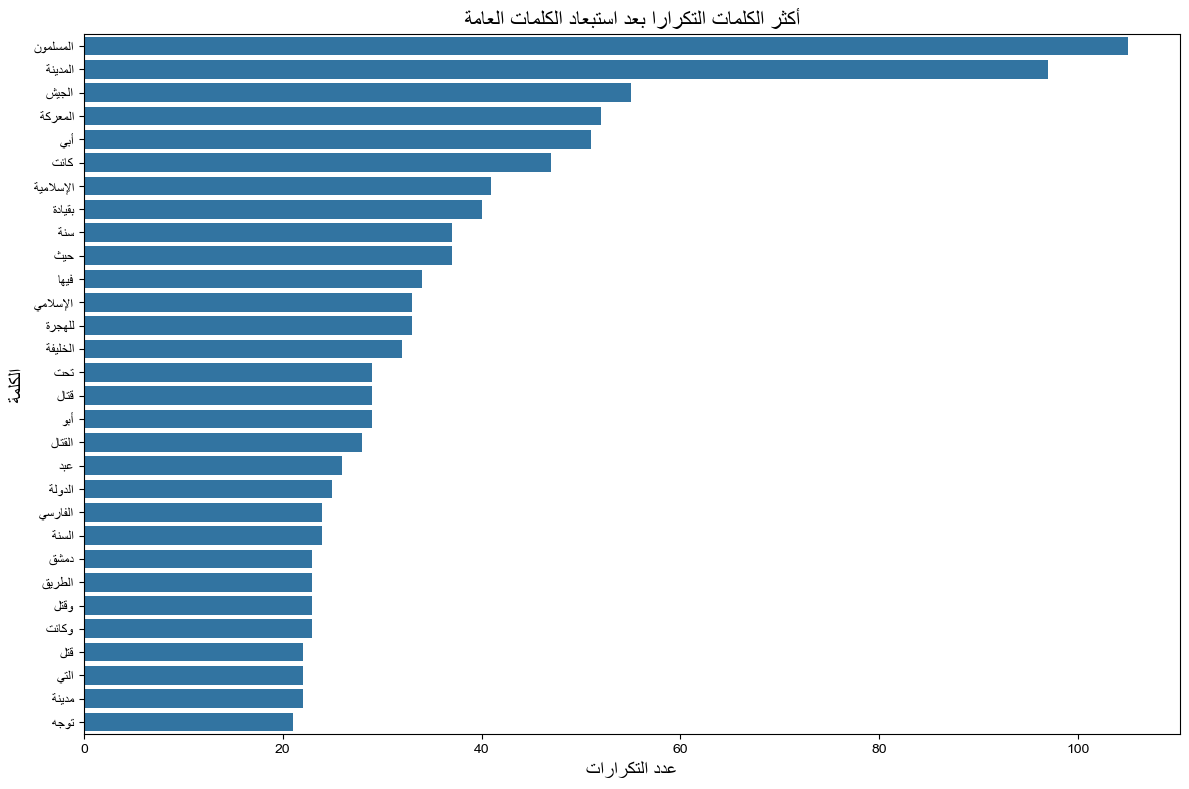

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display

freq_df['الكلمة_معالجة'] = freq_df['الكلمة'].apply(lambda x: get_display(arabic_reshaper.reshape(x)))

# إعداد الخط
plt.rcParams['font.family'] = 'Arial' 

# رسم الرسم البياني
plt.figure(figsize=(12, 8))
sns.barplot(data=freq_df, y='الكلمة_معالجة', x='التكرار')
plt.title(get_display(arabic_reshaper.reshape('أكثر الكلمات التكرارًا بعد استبعاد الكلمات العامة')), fontsize=16)
plt.xlabel(get_display(arabic_reshaper.reshape('عدد التكرارات')), fontsize=14)
plt.ylabel(get_display(arabic_reshaper.reshape('الكلمة')), fontsize=14)
plt.tight_layout()
plt.show()

In [157]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# النصوص (القصة + أسبابها)
texts = df['النص'].tolist()

# إعداد TF-IDF
tfidf = TfidfVectorizer(stop_words=custom_stopwords, max_features=1000)
X = tfidf.fit_transform(texts)
feature_names = tfidf.get_feature_names_out()

# استخراج أعلى 5 كلمات لكل سجل
keywords_per_doc = {}
for i in range(X.shape[0]):
    row = X[i].toarray().flatten()
    top_indices = row.argsort()[-5:][::-1]  # أعلى 5
    top_keywords = [feature_names[j] for j in top_indices if row[j] > 0]
    keywords_per_doc[i] = top_keywords

# تحويلها لبيانات مفهومة
keywords_df = pd.DataFrame({
    'الغزوة': df['الاسم'],
    'الكلمات المفتاحية': [keywords_per_doc[i] for i in range(len(texts))]
})

keywords_df.head()

الغزوة                         الكلمات المفتاحية
0  غزوة ودان أو الأبواء          [قافلة, تمر, ضمرة, ودان, الغزوة]
1             غزوة بواط        [بعير, لقريش, رجل, وخمسمائة, أراد]
2            غزوة سفوان              [جابر, كرز, بدر, بدون, وادي]
3       غزوة ذي العشيرة    [القافلة, التجارية, قافلة, بدون, كانت]
4              غزوة بدر  [المشركين, رجلا, جهل, لاعتراض, وانتصروا]

In [159]:
from IPython.display import display

display(keywords_df)

الغزوة                         الكلمات المفتاحية
0    غزوة ودان أو الأبواء          [قافلة, تمر, ضمرة, ودان, الغزوة]
1               غزوة بواط        [بعير, لقريش, رجل, وخمسمائة, أراد]
2              غزوة سفوان              [جابر, كرز, بدر, بدون, وادي]
3         غزوة ذي العشيرة    [القافلة, التجارية, قافلة, بدون, كانت]
4                غزوة بدر  [المشركين, رجلا, جهل, لاعتراض, وانتصروا]
..                    ...                                       ...
110           موقعة الجمل       [الجمل, عثمان, عائشة, قتلة, الزبير]
111         معركة كفرتوثا        [كميل, جانب, كفرتوثا, الإمام, شاء]
112            معركة صفين        [معاوية, ألفا, ٣٧, أصحاب, التحكيم]
113        معركة النهروان   [الخوارج, التحكيم, جماعة, ينج, للتحكيم]
114             معركة هيت      [هيت, سفيان, المدينة, ببسالة, تعزيز]

[112 rows x 2 columns]

In [161]:
!pip install yake

In [163]:
import yake

# إعداد استخراج الكلمات
language = "ar"
max_ngram_size = 1  
top_n = 5
custom_stopwords_yake = set(custom_stopwords)

kw_extractor = yake.KeywordExtractor(
    lan=language,
    n=max_ngram_size,
    top=top_n,
    stopwords=custom_stopwords_yake
)

# استخراج الكلمات لكل غزوة
yake_keywords = []
for text in df['النص']:
    extracted = kw_extractor.extract_keywords(text)
    top_words = [kw for kw, score in extracted]
    yake_keywords.append(top_words)

# حفظ النتائج في جدول
df['الكلمات المفتاحية (YAKE)'] = yake_keywords

# عرض جزء من النتائج
from IPython.display import display
display(df[['الاسم', 'الكلمات المفتاحية (YAKE)']].head(10))

الاسم               الكلمات المفتاحية (YAKE)
0     غزوة ودان أو الأبواء     [قافلة, رسول, المهاجرين, شهر, صفر]
1                غزوة بواط          [بعير, رجل, شهر, ربيع, الأول]
2               غزوة سفوان         [أغار, قتال, كرز, جابر, مراعي]
3          غزوة ذي العشيرة         [خرج, رجل, حرب, القافلة, كانت]
4                 غزوة بدر  [رجلا, خرج, لحمايتها, لاعتراض, قافلة]
5          غزوة بني قينقاع     [نقض, المدينة, بنو, عهدهم, وكانوا]
6              غزوة السويق         [المدينة, بدر،, خرج, أبو, نفر]
7  غزوة الكدر من بني سُليم   [غنائم, سليم, المدينة, تحرك, مباشرة]
8                 غزوة أحد        [وقبيلة, بقيادة, أحد, جبل, حرب]
9         غزوة حمراء الأسد   [اليوم, المدينة, أحد،, صباح, التالي]

In [165]:
df = df.reset_index(drop=True)

In [167]:
!pip install keybert
!pip install sentence-transformers
!pip install transformers

In [169]:
from keybert import KeyBERT
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
import pandas as pd

# تحميل نموذج AraBERTv2
arabert_model = SentenceTransformer("aubmindlab/bert-base-arabertv2")

# إنشاء كائن KeyBERT
kw_model = KeyBERT(model=arabert_model)

# استخراج الكلمات المفتاحية لكل نص
keybert_keywords = []
for text in df['النص']:
    keywords = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(1, 2),
        stop_words=custom_stopwords,
        top_n=5,
        use_maxsum=True,
        diversity=0.7
    )
    top_keywords = [kw[0] for kw in keywords]
    keybert_keywords.append(top_keywords)

# إضافة النتائج إلى DataFrame
df['الكلمات المفتاحية (KeyBERT)'] = keybert_keywords

No sentence-transformers model found with name aubmindlab/bert-base-arabertv2. Creating a new one with mean pooling.


In [171]:
df['الكلمات المفتاحية (KeyBERT)'] = keybert_keywords
df[['الاسم', 'الكلمات المفتاحية (KeyBERT)']].head(10)

الاسم                        الكلمات المفتاحية (KeyBERT)
0     غزوة ودان أو الأبواء  [سبعون رجلا, ضمرة سيدهم, الثانية للهجرة, بتلك ...
1                غزوة بواط  [الثانية, لعير لقريش, المسلمون, فبلغ قرية, وخم...
2               غزوة سفوان  [وسميت بدر, لوقوعها, رجلا لمطاردته, المدينة فخ...
3          غزوة ذي العشيرة  [القافلة, فرجعوا بدون, ذهبت وبلغوا, القافلة نف...
4                 غزوة بدر  [رجلا لحمايتها, المحدق المتمثل, اشتدت المعركة,...
5          غزوة بني قينقاع  [للهجرة, شهر شوال, فأمر بإجلائهم, عهدهم وكانوا...
6              غزوة السويق  [المسلمون, فخرج طلبه, أبي سفيان, السويق ليخفف,...
7  غزوة الكدر من بني سُليم  [ثلاثة أيام, ومعه غنائم, الذين انسحبوا, بدر ال...
8                 غزوة أحد  [سيد الشهداء, بدر ولاستعادة, الفرسان الفرصة, ع...
9         غزوة حمراء الأسد  [أحدا فاستجابوا, ٱلقرح للذين, الثالثة للهجرة, ...

In [173]:
# إضافة عمود الكلمات المفتاحية (TF-IDF) إلى df
df['الكلمات المفتاحية (TF-IDF)'] = [keywords_per_doc[i] for i in range(len(df))]

# التأكد من أن القيم كلها قوائم
for col in ['الكلمات المفتاحية (TF-IDF)', 'الكلمات المفتاحية (YAKE)', 'الكلمات المفتاحية (KeyBERT)']:
    df[col] = df[col].apply(lambda x: x if isinstance(x, list) else [])

# إنشاء مقارنة بين الطرق الثلاث
comparison_results = []
for i in range(len(df)):
    tfidf_set = set(df.loc[i, 'الكلمات المفتاحية (TF-IDF)'])
    yake_set = set(df.loc[i, 'الكلمات المفتاحية (YAKE)'])
    keybert_set = set(df.loc[i, 'الكلمات المفتاحية (KeyBERT)'])

    common_yake = tfidf_set & yake_set
    common_keybert = tfidf_set & keybert_set
    common_all = tfidf_set & yake_set & keybert_set

    result = {
        'الاسم': df.loc[i, 'الاسم'],
        'TF-IDF': list(tfidf_set),
        'YAKE': list(yake_set),
        'KeyBERT': list(keybert_set),
        'مشتركة YAKE-TFIDF': list(common_yake),
        'عددها': len(common_yake),
        'مشتركة KeyBERT-TFIDF': list(common_keybert),
        'عددها ': len(common_keybert),
        'مشتركة الكل': list(common_all),
        'عدد مشتركة الكل': len(common_all)
    }

    comparison_results.append(result)

# تحويل إلى DataFrame وعرض النتائج
triple_compare_df = pd.DataFrame(comparison_results)
from IPython.display import display

In [175]:
display(triple_compare_df)

الاسم                                    TF-IDF  \
0    غزوة ودان أو الأبواء          [ودان, ضمرة, تمر, الغزوة, قافلة]   
1               غزوة بواط        [رجل, وخمسمائة, بعير, لقريش, أراد]   
2              غزوة سفوان              [كرز, بدر, جابر, وادي, بدون]   
3         غزوة ذي العشيرة    [القافلة, التجارية, كانت, قافلة, بدون]   
4                غزوة بدر  [رجلا, وانتصروا, جهل, لاعتراض, المشركين]   
..                    ...                                       ...   
107           موقعة الجمل       [عثمان, عائشة, قتلة, الجمل, الزبير]   
108         معركة كفرتوثا        [كفرتوثا, الإمام, شاء, جانب, كميل]   
109            معركة صفين        [٣٧, التحكيم, ألفا, أصحاب, معاوية]   
110        معركة النهروان   [التحكيم, للتحكيم, ينج, الخوارج, جماعة]   
111             معركة هيت      [سفيان, ببسالة, تعزيز, المدينة, هيت]   

                                      YAKE  \
0       [رسول, المهاجرين, شهر, صفر, قافلة]   
1            [رجل, ربيع, بعير, شهر, الأول]   
2           [كرز, مراعي, أغار, قتال, جابر]   
3           [رجل, خرج, القافلة, حرب, كانت]   
4    [رجلا, خرج, لحمايتها, لاعتراض, قافلة]   
..                                     ...   
107    [بالقصاص, سنة, عثمان, ألفا،, هجري،]   
108       [سفيان, أبي, قوات, الإمام, كميل]   
109           [أرض, صفين, بعام, أبي, وقعت]   
110    [وقضية, التحكيم،, صفين, انشقت, أبي]   
111    [سفيان, أبي, بقيادة, طالب, المدينة]   

                                               KeyBERT مشتركة YAKE-TFIDF  \
0    [الثانية للهجرة, ضمرة سيدهم, فإنهم ينصرونه, سب...           [قافلة]   
1    [فبلغ قرية, لعير لقريش, المسلمون, الثانية, وخم...       [رجل, بعير]   
2    [لوقوعها, وسميت بدر, رجلا لمطاردته, وادي سفوان...       [كرز, جابر]   
3    [ذهبت وبلغوا, القافلة, فرجعوا بدون, القافلة نف...   [القافلة, كانت]   
4    [المحدق المتمثل, لنصر وانتصروا, الجزيرة العربي...   [لاعتراض, رجلا]   
..                                                 ...               ...   
107  [المسلمون, مقتل الخليفة, ليلا انتهت, للقصاص ال...           [عثمان]   
108  [التجارية والعسكرية, النصر المبين, الجيشان كفر...    [الإمام, كميل]   
109  [عثمان عفان, للتحكيم, رمضان سنة, وإن المشهور, ...                []   
110  [وبدأوا يقتلون, فرجع بعضهم, للتحكيم, الأبرياء ...                []   
111  [سبقت النهروان, الفرزدق ببسالة, أبي سفيان, نهر...  [سفيان, المدينة]   

     عددها مشتركة KeyBERT-TFIDF  عددها  مشتركة الكل  عدد مشتركة الكل  
0        1                   []       0          []                0  
1        2                   []       0          []                0  
2        2                   []       0          []                0  
3        2            [القافلة]       1   [القافلة]                1  
4        2                   []       0          []                0  
..     ...                  ...     ...         ...              ...  
107      1                   []       0          []                0  
108      2                   []       0          []                0  
109      0                   []       0          []                0  
110      0            [للتحكيم]       1          []                0  
111      2                   []       0          []                0  

[112 rows x 10 columns]

In [177]:
print(" متوسط التشابه TF-IDF vs YAKE:", triple_compare_df['عددها'].mean())
print(" متوسط التشابه TF-IDF vs KeyBERT:", triple_compare_df['عددها '].mean())
print(" متوسط التشابه بين الثلاثة:", triple_compare_df['عدد مشتركة الكل'].mean())

 متوسط التشابه TF-IDF vs YAKE: 1.4375
 متوسط التشابه TF-IDF vs KeyBERT: 0.0625
 متوسط التشابه بين الثلاثة: 0.017857142857142856


In [179]:
!pip install rake-nltk

In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Batoo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [181]:
from rake_nltk import Rake
from nltk.corpus import stopwords

# كلمات التوقف بالعربية
arabic_stopwords = custom_stopwords  

# إنشاء كائن RAKE
rake_extractor = Rake(
    stopwords=arabic_stopwords,
    language='arabic'
)

# استخراج الكلمات المفتاحية لكل نص
rake_keywords = []
for text in df['النص']:
    try:
        rake_extractor.extract_keywords_from_text(text)
        ranked_phrases = rake_extractor.get_ranked_phrases()[:5]  # أعلى 5
    except:
        ranked_phrases = []
    rake_keywords.append(ranked_phrases)

# إضافة النتائج إلى DataFrame
df['الكلمات المفتاحية (RAKE)'] = rake_keywords

In [183]:
from IPython.display import display

# عرض جدول شامل لكل النتائج المستخرجة من RAKE
display(df[['الاسم', 'النص', 'الكلمات المفتاحية (RAKE)']])

الاسم                                               النص  \
0    غزوة ودان أو الأبواء  في شهر صفر من السنة الثانية للهجرة، خرج رسول ا...   
1               غزوة بواط  في شهر ربيع الأول السنة الثانية للهجرة، خرج رس...   
2              غزوة سفوان  أغار كرز بن جابر الفهري بقوة خفيفة على مراعي ا...   
3         غزوة ذي العشيرة  خرج الرسول ﷺ ب 150 أو 200 رجل للقاء قافلة قريش...   
4                غزوة بدر  خرج الرسول ﷺ ب313 رجلا لاعتراض قافلة قريش التج...   
..                    ...                                                ...   
107           موقعة الجمل  في سنة 36 هجري، وقعت موقعة الجمل بعد مقتل الخل...   
108         معركة كفرتوثا  في خضم أحداث الفتنة الكبرى، وقعت معركة كفرتوثا...   
109            معركة صفين  وقعت معركة صفين في أرض تسمى صفين (قرب الرقة ال...   
110        معركة النهروان  بعد معركة صفين وقضية التحكيم، انشقت جماعة من ج...   
111             معركة هيت  في معركة هيت، حاصر جيش معاوية بن أبي سفيان بقي...   

                              الكلمات المفتاحية (RAKE)  
0    [بالجيش ليعترض قافلة لقريش كانت تمر بتلك المنا...  
1    [شهر ربيع الأول السنة الثانية للهجرة ، خرج رسو...  
2    [وادي سفوان ، فرجع بدون قتال, بسبعين رجلا لمطا...  
3    [ذي العشيرة "، لكن القافلة كانت, سبقتهم بأيام ...  
4    [، وانتصروا انتصارا ساحقا ، حيث قتل 70, الخطر ...  
..                                                 ...  
107  [ورغم محاولات الصلح ، أشعلت فرقة متطرفة القتال...  
108  [المعركة حكمة كميل العسكرية حين منع مطاردة الف...  
109  [استمر القتال تسعة أيام ، واشترك فيه كبار الصح...  
110  [نصرا كاسحا ، وقتل معظم الخوارج ، ولم ينج إلا ...  
111  [دافع أهالي المدينة بقيادة الشاعر الفرزدق ببسا...  

[112 rows x 3 columns]

In [185]:
# نحول أي قيمة ليست قائمة إلى قائمة فارغة
for col in ['الكلمات المفتاحية (TF-IDF)', 'الكلمات المفتاحية (YAKE)', 'الكلمات المفتاحية (KeyBERT)', 'الكلمات المفتاحية (RAKE)']:
    df[col] = df[col].apply(lambda x: x if isinstance(x, list) else [])

In [187]:
comparison_results = []

for i in range(len(df)):
    tfidf_set = set(df.loc[i, 'الكلمات المفتاحية (TF-IDF)'])
    yake_set = set(df.loc[i, 'الكلمات المفتاحية (YAKE)'])
    keybert_set = set(df.loc[i, 'الكلمات المفتاحية (KeyBERT)'])
    rake_set = set(df.loc[i, 'الكلمات المفتاحية (RAKE)'])

    common_tfidf_rake = tfidf_set & rake_set
    common_yake_rake = yake_set & rake_set
    common_keybert_rake = keybert_set & rake_set
    common_all = tfidf_set & yake_set & keybert_set & rake_set

    result = {
        'الاسم': df.loc[i, 'الاسم'],
        'TF-IDF': list(tfidf_set),
        'RAKE': list(rake_set),
        'YAKE': list(yake_set),
        'KeyBERT': list(keybert_set),
        'مشتركة TFIDF-RAKE': list(common_tfidf_rake),
        'عددها 1': len(common_tfidf_rake),
        'مشتركة YAKE-RAKE': list(common_yake_rake),
        'عددها 2': len(common_yake_rake),
        'مشتركة KeyBERT-RAKE': list(common_keybert_rake),
        'عددها 3': len(common_keybert_rake),
        'مشتركة الكل': list(common_all),
        'عدد مشتركة الكل': len(common_all)
    }

    comparison_results.append(result)

# تحويل إلى DataFrame
rake_compare_df = pd.DataFrame(comparison_results)

# عرض أول النتائج
from IPython.display import display
display(rake_compare_df[['الاسم', 'TF-IDF', 'RAKE', 'YAKE', 'KeyBERT', 'مشتركة TFIDF-RAKE', 'عددها 1', 'مشتركة YAKE-RAKE', 'عددها 2', 'مشتركة KeyBERT-RAKE', 'عددها 3', 'مشتركة الكل', 'عدد مشتركة الكل']].head(10))

الاسم                                    TF-IDF  \
0     غزوة ودان أو الأبواء          [ودان, ضمرة, تمر, الغزوة, قافلة]   
1                غزوة بواط        [رجل, وخمسمائة, بعير, لقريش, أراد]   
2               غزوة سفوان              [كرز, بدر, جابر, وادي, بدون]   
3          غزوة ذي العشيرة    [القافلة, التجارية, كانت, قافلة, بدون]   
4                 غزوة بدر  [رجلا, وانتصروا, جهل, لاعتراض, المشركين]   
5          غزوة بني قينقاع         [قينقاع, سوق, نقض, عهدهم, فاشتبك]   
6              غزوة السويق        [سفيان, وترك, بدر, الثأر, الأنصار]   
7  غزوة الكدر من بني سُليم         [وردت, مباشرة, حشود, غنائم, سليم]   
8                 غزوة أحد              [وقبيلة, بدر, جبل, عدد, أحد]   
9         غزوة حمراء الأسد         [يهزموا, الأسد, يظهر, حمراء, أحد]   

                                                RAKE  \
0  [السنة الثانية للهجرة ، خرج رسول, يلقوا قافلة ...   
1  [شهر ربيع الأول السنة الثانية للهجرة ، خرج رسو...   
2  [بسبعين رجلا لمطاردته ، ولكنه, وادي سفوان ، فر...   
3  [ذي العشيرة "، لكن القافلة كانت, ، وبلغوا منطق...   
4  [الخطر المحدق المتمثل باعتراض عير لقريش متوجهة...   
5  [فتعرضوا لٱمرأة مسلمة ، فاشتبك أحد, معهم فقتلو...   
6  [تفلت ، وترك أكياسا, محاولة أبي سفيان الثأر له...   
7  [ثلاثة أيام ، ومعه غنائم, الكدر ، وباغت, سليم ...   
8  [بداية المعركة ، انتصر المسلمون وفر المشركون ،...   
9  [ٓ أصابهم ٱلقرح ۚ للذين أحسنوا ۟ منهم وٱتقوا ۟...   

                                    YAKE  \
0     [رسول, المهاجرين, شهر, صفر, قافلة]   
1          [رجل, ربيع, بعير, شهر, الأول]   
2         [كرز, مراعي, أغار, قتال, جابر]   
3         [رجل, خرج, القافلة, حرب, كانت]   
4  [رجلا, خرج, لحمايتها, لاعتراض, قافلة]   
5     [وكانوا, بنو, نقض, عهدهم, المدينة]   
6         [أبو, خرج, بدر،, نفر, المدينة]   
7   [تحرك, مباشرة, غنائم, المدينة, سليم]   
8        [وقبيلة, حرب, بقيادة, جبل, أحد]   
9   [التالي, اليوم, صباح, أحد،, المدينة]   

                                             KeyBERT مشتركة TFIDF-RAKE  \
0  [الثانية للهجرة, ضمرة سيدهم, فإنهم ينصرونه, سب...                []   
1  [فبلغ قرية, لعير لقريش, المسلمون, الثانية, وخم...                []   
2  [لوقوعها, وسميت بدر, رجلا لمطاردته, وادي سفوان...                []   
3  [ذهبت وبلغوا, القافلة, فرجعوا بدون, القافلة نف...                []   
4  [المحدق المتمثل, لنصر وانتصروا, الجزيرة العربي...                []   
5  [فأمر بإجلائهم, شهر شوال, عهدهم وكانوا, بنو قي...                []   
6  [فر هاربا, فخرج طلبه, المسلمون, السويق ليخفف, ...                []   
7  [ومعه غنائم, ثلاثة أيام, الذين انسحبوا, انسحبو...                []   
8  [سيد الشهداء, الفرسان الفرصة, جبل الرماة, عدد ...                []   
9  [الثالثة للهجرة, الليل أوقدوا, للمشركين يهزموا...                []   

   عددها 1 مشتركة YAKE-RAKE  عددها 2 مشتركة KeyBERT-RAKE  عددها 3 مشتركة الكل  \
0        0               []        0                  []        0          []   
1        0               []        0                  []        0          []   
2        0               []        0                  []        0          []   
3        0               []        0                  []        0          []   
4        0               []        0                  []        0          []   
5        0               []        0                  []        0          []   
6        0               []        0                  []        0          []   
7        0               []        0                  []        0          []   
8        0               []        0                  []        0          []   
9        0               []        0                  []        0          []   

   عدد مشتركة الكل  
0                0  
1                0  
2                0  
3                0  
4                0  
5                0  
6                0  
7                0  
8                0  
9                0

In [189]:
for i in range(len(df)):
    print(f"📌 {df.loc[i, 'الاسم']}")
    print(f" النص: {df.loc[i, 'النص']}")
    print(f"كلمات RAKE: {df.loc[i, 'الكلمات المفتاحية (RAKE)']}")
    print('-' * 80)

📌 غزوة ودان أو الأبواء
 النص: في شهر صفر من السنة الثانية للهجرة، خرج رسول الله ﷺ بنفسه في أولى غزواته، وكان معه سبعون رجلا من المهاجرين. وقد استخلف النبي ﷺ على المدينة سعد بن عبادة رضي الله عنه، ثم توجه النبي ﷺ بالجيش ليعترض قافلة لقريش كانت تمر بتلك المناطق. وصل الجيش إلى منطقة ودان (وتسمى أيضا الأبواء)، ولكنهم لم يلقوا قافلة ولا حدث قتال. وفي هذه الغزوة، عقد رسول الله ﷺ معاهدة أمن وسلم مع بني ضمرة، وكان سيدهم يدعى عمرو بن مخشي الضمري. وقد نصت المعاهدة على: أن يكون بين المسلمين وبني ضمرة أمن وسلم. وأن لا يناصروا أعداء النبي ﷺ. وإذا احتاج النبي ﷺ إلى نصرتهم، فإنهم ينصرونه. وكان لواء الغزوة أبيض، وقد حمله حمزة بن عبد المطلب رضي الله عنه. ودامت الغزوة خمسة عشر يوما، ثم رجع رسول الله ﷺ ومن معه إلى المدينة. أراد الرسول ﷺ اعتراض قافلة لقريش تمر من قرية ودان
كلمات RAKE: ['بالجيش ليعترض قافلة لقريش كانت تمر بتلك المناطق', 'ودامت الغزوة خمسة عشر يوما ،', 'السنة الثانية للهجرة ، خرج رسول', 'يلقوا قافلة ولا حدث قتال', 'وتسمى أيضا الأبواء )، ولكنهم']
---------------------------------------------

In [191]:
# إعداد الوزن لكل خوارزمية
weights = {
    'TF-IDF': 0.4,
    'RAKE': 0.3,
    'KeyBERT': 0.3
}

# عدد الكلمات النهائية لكل غزوة
final_keywords_count = 5

# إنشاء القائمة النهائية لكل غزوة
hybrid_keywords = []

# التأكد من وجود الأعمدة المطلوبة
required_cols = ['الكلمات المفتاحية (TF-IDF)', 'الكلمات المفتاحية (RAKE)', 'الكلمات المفتاحية (KeyBERT)']
if all(col in df.columns for col in required_cols):
    for i in range(len(df)):
        score_dict = {}

        for method, weight in weights.items():
            words = df.loc[i, f'الكلمات المفتاحية ({method})']
            for rank, word in enumerate(words):
                score = (len(words) - rank) / len(words)  # كلما كانت الكلمة أعلى، كانت أقوى
                score_dict[word] = score_dict.get(word, 0) + score * weight

        # ترتيب الكلمات حسب المجموع وأخذ أعلى n
        top_keywords = sorted(score_dict.items(), key=lambda x: x[1], reverse=True)
        hybrid_keywords.append([word for word, _ in top_keywords[:final_keywords_count]])

    # إضافة إلى DataFrame
    df['الكلمات المفتاحية (هجينة موزونة)'] = hybrid_keywords

# عرض النتائج
df[['الاسم', 'الكلمات المفتاحية (هجينة موزونة)']].head(10)

الاسم                   الكلمات المفتاحية (هجينة موزونة)
0     غزوة ودان أو الأبواء  [قافلة, تمر, بالجيش ليعترض قافلة لقريش كانت تم...
1                غزوة بواط  [بعير, لقريش, شهر ربيع الأول السنة الثانية لله...
2               غزوة سفوان  [جابر, كرز, وادي سفوان ، فرجع بدون قتال, وسميت...
3          غزوة ذي العشيرة  [القافلة, التجارية, ذي العشيرة "، لكن القافلة ...
4                 غزوة بدر  [المشركين, رجلا, ، وانتصروا انتصارا ساحقا ، حي...
5          غزوة بني قينقاع  [قينقاع, نقض, إليهم ، وحاصرهم خمس عشرة ليلة ،,...
6              غزوة السويق  [بدر, سفيان, السويق ليخفف حمله ، فغنمها المسلم...
7  غزوة الكدر من بني سُليم  [سليم, حشود, ثلاثة أيام ، ومعه غنائم, ثلاثة أي...
8                 غزوة أحد  [أحد, جبل, سورة آل عمران ، تواسي المؤمنين ، وت...
9         غزوة حمراء الأسد  [يظهر, يهزموا, ٓ أصابهم ٱلقرح ۚ للذين أحسنوا ۟...

In [193]:
#LDA

In [195]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from collections import defaultdict
import pandas as pd

# تحويل الكلمات لنصوص
text_data = df['الكلمات المفتاحية (هجينة موزونة)'].apply(lambda x: ' '.join(x)).tolist()

# تجهيز الفكتورايزر
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(text_data)
feature_names = vectorizer.get_feature_names_out()

def get_coherence_score(topics, texts):
    # طريقة مبسطة لحساب الكوهيرنس (ليست دقيقة مثل gensim)
    score = 0
    for topic in topics:
        count = 0
        for i in range(len(topic)):
            for j in range(i+1, len(topic)):
                w1, w2 = topic[i], topic[j]
                cooccur = sum([1 for t in texts if w1 in t and w2 in t])
                count += cooccur
        score += count
    return score / len(topics)

# نجهز النصوص الأصلية بالتوكنز
tokenized_texts = [x for x in df['الكلمات المفتاحية (هجينة موزونة)']]

results = []

for n_topics in range(2, 9):  # من 2 إلى 8
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)
    
    # استخراج أهم الكلمات لكل موضوع
    topics = []
    for topic in lda.components_:
        top_words = [feature_names[i] for i in topic.argsort()[:-6:-1]]
        topics.append(top_words)
    
    coherence = get_coherence_score(topics, tokenized_texts)
    results.append({'num_topics': n_topics, 'coherence': coherence})
    print(f"عدد المواضيع = {n_topics}, Coherence Score = {coherence:.4f}")

# عرض النتائج في جدول
results_df = pd.DataFrame(results)
display(results_df)


عدد المواضيع = 2, Coherence Score = 0.5000
عدد المواضيع = 3, Coherence Score = 0.3333
عدد المواضيع = 4, Coherence Score = 0.2500
عدد المواضيع = 5, Coherence Score = 0.6000
عدد المواضيع = 6, Coherence Score = 1.0000
عدد المواضيع = 7, Coherence Score = 1.1429
عدد المواضيع = 8, Coherence Score = 1.0000


num_topics  coherence
0           2   0.500000
1           3   0.333333
2           4   0.250000
3           5   0.600000
4           6   1.000000
5           7   1.142857
6           8   1.000000

In [197]:
from sklearn.feature_extraction.text import CountVectorizer

# تحويل الكلمات إلى نصوص عادية
text_data = df['الكلمات المفتاحية (هجينة موزونة)'].apply(lambda x: ' '.join(x))

# تحويلها إلى مصفوفة
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(text_data)

In [199]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda.fit_transform(X)

In [201]:
# الموضوع المهيمن في كل صف
df['موضوع_LDA'] = lda_topics.argmax(axis=1)

In [203]:
def display_lda_topics(model, feature_names, n_top_words=5):
    for idx, topic in enumerate(model.components_):
        words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"🔹 الموضوع {idx}: {', '.join(words)}")

display_lda_topics(lda, vectorizer.get_feature_names_out())

🔹 الموضوع 0: المسلمون, فإن, مكة, الإسلامي, قتل
🔹 الموضوع 1: المسلمون, المدينة, الخليفة, حيث, أبي
🔹 الموضوع 2: المسلمون, بعض, بدر, فيه, عثمان
🔹 الموضوع 3: دمشق, المسلمون, بقيادة, المدينة, خراسان
🔹 الموضوع 4: المسلمون, المدينة, كبيرة, للهجرة, كانت


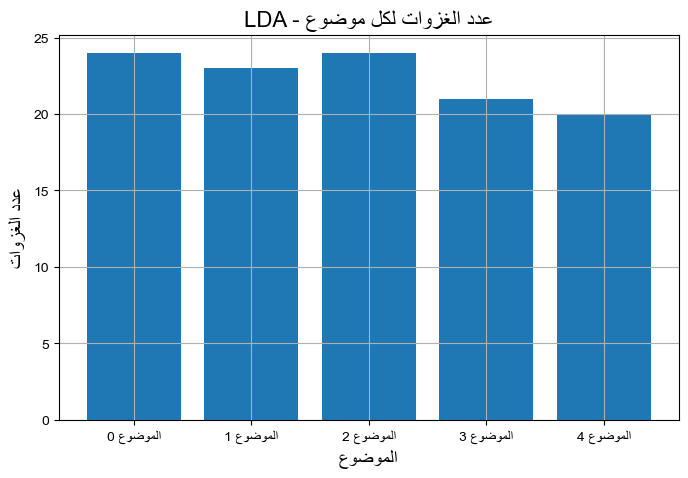

In [205]:
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

counts = df['موضوع_LDA'].value_counts().sort_index()
labels = [get_display(arabic_reshaper.reshape(f"الموضوع {i}")) for i in counts.index]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts)
plt.title(get_display(arabic_reshaper.reshape("عدد الغزوات لكل موضوع - LDA")), fontsize=16)
plt.xlabel(get_display(arabic_reshaper.reshape("الموضوع")), fontsize=14)
plt.ylabel(get_display(arabic_reshaper.reshape("عدد الغزوات")), fontsize=14)
plt.grid(True)
plt.show()

In [207]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# النصوص = [['كلمة1', 'كلمة2'], ['كلمة3', 'كلمة4']] → ندمجها
text_data = df['الكلمات المفتاحية (هجينة موزونة)'].apply(lambda x: ' '.join(x))

# 1. تحويل النصوص إلى تمثيل عددي
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(text_data)

# 2. بناء نموذج LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda.fit_transform(X)

# 3. تخصيص الموضوع الأقرب لكل نص
df['موضوع_LDA'] = lda_topics.argmax(axis=1)

# 4. عرض أهم الكلمات في كل موضوع
def display_lda_topics(model, feature_names, n_top_words=6):
    for idx, topic in enumerate(model.components_):
        words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"🟢 الموضوع {idx}: {'، '.join(words)}")

display_lda_topics(lda, vectorizer.get_feature_names_out())

🟢 الموضوع 0: المسلمون، فإن، مكة، الإسلامي، قتل، المعركة
🟢 الموضوع 1: المسلمون، المدينة، الخليفة، حيث، أبي، وقتل
🟢 الموضوع 2: المسلمون، بعض، بدر، فيه، عثمان، كانت
🟢 الموضوع 3: دمشق، المسلمون، بقيادة، المدينة، خراسان، فيها
🟢 الموضوع 4: المسلمون، المدينة، كبيرة، للهجرة، كانت، فارس


In [209]:
# نحسب تمثيل كل موضوع كمتوسط توزيع الكلمات في مكوناته
topic_word_distributions = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

# نحسب التشابه بين كل المواضيع
similarity_matrix = cosine_similarity(topic_word_distributions)

# نحذف التشابه الذاتي (القُطر)
np.fill_diagonal(similarity_matrix, np.nan)

# متوسط التشابه = عكس التمايز = نطرح من 1
coherence_score = 1 - np.nanmean(similarity_matrix)
print(f"\n📈 Coherence Score (بدون Gensim): {coherence_score:.4f}")


📈 Coherence Score (بدون Gensim): 0.5680


In [211]:
for topic_num in sorted(df['موضوع_LDA'].unique()):
    print(f"\n🟢 الموضوع {topic_num}:")
    display(df[df['موضوع_LDA'] == topic_num][['الاسم', 'الكلمات المفتاحية (هجينة موزونة)']].head(5))


🟢 الموضوع 0:


الاسم                   الكلمات المفتاحية (هجينة موزونة)
5           غزوة بني قينقاع  [قينقاع, نقض, إليهم ، وحاصرهم خمس عشرة ليلة ،,...
7   غزوة الكدر من بني سُليم  [سليم, حشود, ثلاثة أيام ، ومعه غنائم, ثلاثة أي...
11      غزوة الفرع من بحران  [بحران, بالقرب, الفرع ، فلم يجد أحدا ،, المدين...
12          غزوة بني النضير  [النضير, ذهب, رواية خمسة عشر يوما -، فقطع النخ...
23                غزوة خيبر  [خيبر, حصون, وبعد يومين قدمت امرأة يهودية شاة ...


🟢 الموضوع 1:


الاسم                   الكلمات المفتاحية (هجينة موزونة)
6             غزوة السويق  [بدر, سفيان, السويق ليخفف حمله ، فغنمها المسلم...
9        غزوة حمراء الأسد  [يظهر, يهزموا, ٓ أصابهم ٱلقرح ۚ للذين أحسنوا ۟...
14  غَزْوَةُ ذات الرِّقاع  [عباد, للهجوم, شقت الحجارة الجرداء أقدامهم ، ف...
29          معركة اليمامة  [جمع, اليمامة, اليمامة رجل يدعى مسيلمة الكذاب ...
30            معركة بزاخة  [طليحة, لقتاله, خزيمة وبنو غطفان ، وزعم أنه يأ...


🟢 الموضوع 2:


الاسم                   الكلمات المفتاحية (هجينة موزونة)
0   غزوة ودان أو الأبواء  [قافلة, تمر, بالجيش ليعترض قافلة لقريش كانت تم...
2             غزوة سفوان  [جابر, كرز, وادي سفوان ، فرجع بدون قتال, وسميت...
4               غزوة بدر  [المشركين, رجلا, ، وانتصروا انتصارا ساحقا ، حي...
8               غزوة أحد  [أحد, جبل, سورة آل عمران ، تواسي المؤمنين ، وت...
13       غزوة بدر الآخرة  [وبدر, بدر, يصلحكم إلا عام خصب ، ترعون فيه الش...


🟢 الموضوع 3:


الاسم                   الكلمات المفتاحية (هجينة موزونة)
1           غزوة بواط  [بعير, لقريش, شهر ربيع الأول السنة الثانية لله...
28          غزوة تبوك  [كانت, خرج, قبائل كثيرة ، وأظهر المسلمون وحدته...
40  معركة ذات العيون   [الأنبار, الحصن, الحصار وضرب الحصن بسهام دقيقة...
41  معركة ذات السلاسل  [هرمز, السلاسل, ردع التهديد الفارسي ، توسيع نف...
49    معركة مرج الصفر  [للروم, دمشق, التنفيذ ، مستخدما عنصري المفاجأة...


🟢 الموضوع 4:


الاسم  \
3              غزوة ذي العشيرة   
10                 غزوة ذي أمر   
15            غزوة دومة الجندل   
16  غزوة الخندق (غزوة الأحزاب)   
17              غزوة بني قريظة   

                     الكلمات المفتاحية (هجينة موزونة)  
3   [القافلة, التجارية, ذي العشيرة "، لكن القافلة ...  
10  [غطفان, بلغ, غطفان ، منهم بنو ثعلبة ومحارب ، ي...  
15  [دومة, الجندل, وقيل إنهم كانوا يقطعون الطريق ،...  
16  [الأحزاب, الخندق, حفر المسلمون الخندق بجهد كبي...  
17  [قريظة, عائشة, الجاهلية )، فقضى بقتل الرجال وس...

In [213]:
for topic_num in sorted(df['موضوع_LDA'].unique()):
    print(f"\n🟢 الموضوع {topic_num}:")
    display(df[df['موضوع_LDA'] == topic_num][['الاسم', 'الكلمات المفتاحية (هجينة موزونة)']])



🟢 الموضوع 0:


الاسم  \
5            غزوة بني قينقاع   
7    غزوة الكدر من بني سُليم   
11       غزوة الفرع من بحران   
12           غزوة بني النضير   
23                 غزوة خيبر   
24               معركة مؤتة    
25                   فتح مكة   
26                 غزوة حنين   
32                 معركة دبا   
34              معركة الزميل   
43         معركة دومة الجندل   
44              معركة الولجة   
47              معركة الحصيد   
48              معركة ياقوصة   
51              معركة البويب   
52            معركة بابل 634   
53               معركة بيسان   
66            معركة القادسية   
73              فتح اللاذقية   
85              معركة نهاوند   
87        معركة دنقلا الأولى   
94                 فتح همذان   
108            معركة كفرتوثا   
109               معركة صفين   

                      الكلمات المفتاحية (هجينة موزونة)  
5    [قينقاع, نقض, إليهم ، وحاصرهم خمس عشرة ليلة ،,...  
7    [سليم, حشود, ثلاثة أيام ، ومعه غنائم, ثلاثة أي...  
11   [بحران, بالقرب, الفرع ، فلم يجد أحدا ،, المدين...  
12   [النضير, ذهب, رواية خمسة عشر يوما -، فقطع النخ...  
23   [خيبر, حصون, وبعد يومين قدمت امرأة يهودية شاة ...  
24   [قتل, فإن, ثلاثة آلاف يمهد بها لمعركة كبرى ، ف...  
25   [مكة, دخل, دخل المسلمون مكة دون قتال كبير ، حي...  
26   [مكة, حنين, انقلبت الكفة ، وثبت المسلمون ، وهز...  
32   [وفاة, بعض, لمحاربة لقيط وأتباعه المرتدين ، وا...  
34   [الزميل, سيف, استمرار الزحف الإسلامي ، تفكيك ق...  
43   [عياض, هاجم, بدأ عياض الحصار ، ولما طال وتعب ا...  
44   [منطقة, الجيش, المعركة خطة عسكرية ماهرة ، فقام...  
47   [زرمهر, القعقاع, شديدة ، وقاتل المسلمون قتالا ...  
48   [ياقوصة, دمشق, التي استخدم فيها الحركة السريعة...  
51   [المثنى, الجسر, للأراضي التي خسروها ، وكانت تم...  
52   [بابل, المثنى, ، ولكن المثنى أبلى بلاء حسنا ، ...  
53   [الإسلامي, بيسان, عند الفجر ، بدأ الهجوم الإسل...  
66   [اليوم, يوم, اليوم الثالث ، يوم عماس ، عادت ال...  
73   [عبادة, البيزنطية, دخل المسلمون المدينة وفتحوه...  
85   [النعمان, نهاوند, ، اعتمد المسلمون خطة ذكية با...  
87   [سنة, جنوبا, الرمي بالسهام ، واستخدموا تكتيكات...  
94   [جرير, همذان, مقدمته ، وتم ضم المدينة لاحقا, ع...  
108  [كميل, جانب, المعركة حكمة كميل العسكرية حين من...  
109  [معاوية, ألفا, استمر القتال تسعة أيام ، واشترك...


🟢 الموضوع 1:


الاسم                   الكلمات المفتاحية (هجينة موزونة)
6              غزوة السويق  [بدر, سفيان, السويق ليخفف حمله ، فغنمها المسلم...
9         غزوة حمراء الأسد  [يظهر, يهزموا, ٓ أصابهم ٱلقرح ۚ للذين أحسنوا ۟...
14   غَزْوَةُ ذات الرِّقاع  [عباد, للهجوم, شقت الحجارة الجرداء أقدامهم ، ف...
29           معركة اليمامة  [جمع, اليمامة, اليمامة رجل يدعى مسيلمة الكذاب ...
30             معركة بزاخة  [طليحة, لقتاله, خزيمة وبنو غطفان ، وزعم أنه يأ...
31               معركة ظفر  [أم, المرتدين, بزاخة, وهزمهم, بزاخة ، وانضم إل...
36            معركة المصيخ  [العدو, وقع, توجيه الخليفة أبي بكر بخطوة هجومي...
46     معركة الثني, المذار  [قارن, وقتل, شهر صفر سنة ١٢ للهجرة ، الموافق س...
50                فتح بصرى  [بصرى, جمادى, الحصار والاقتحام ، طلب أهل المدي...
56              معركة دائن  [حول, البيزنطيون, قرية دائن ، حيث انهزم البيزن...
60              معركة فحل   [فحل, بيلا, الوحل ، فانتهز المسلمون الفرصة وهز...
61              معركة كسكر  [ضفاف, يحكمها, النصر أولى حلقات سقوط الإمبراطو...
62     معركة الجسر الحديدي  [الانتصار, الأناضول, تمركز القتال قرب جسر حديد...
63             موقعة الجسر  [الجسر, عبيد, عنيفة جدا أبلى فيها المسلمون بلا...
67           معركة اليرموك  [اليرموك, بلاد, مدى 6 أيام ، أبلى فيها المسلمو...
70                 فتح حمص  [بحصارها, حمص, بيزنطي, أنفسهم وأموالهم وكنائسه...
79            معركة الحاضر  [ميناس, البيزنطيين, الجنود ، اشتعل غضب الجنود ...
84            معركة اصفهان  [عبد, عتبان, عتبان – مدعوما بأبي موسى الأشعري ...
88    الفتح الاسلامي لفارس  [فارس, تحت, بفتح بقية أراضي فارس بقيادة أشهر ا...
89           معركة واج روذ  [المقاومة, الفارسي, حركة تكتيكية ذكية ، حيث تظ...
91              معركة راسل  [السند, مكران, الضفة الغربية لنهر السند ، وكان...
107            موقعة الجمل  [الجمل, عثمان, ورغم محاولات الصلح ، أشعلت فرقة...
111              معركة هيت  [هيت, سفيان, دافع أهالي المدينة بقيادة الشاعر ...


🟢 الموضوع 2:


الاسم  \
0                         غزوة ودان أو الأبواء   
2                                   غزوة سفوان   
4                                     غزوة بدر   
8                                     غزوة أحد   
13                             غزوة بدر الآخرة   
18             غزوة بني المصطلق(غزوة المريسيع)   
19                              غزوة بني لحيان   
21                                  معركة غمرة   
27                                 غزوة الطائف   
35                                معركة الفراض   
37                                 معركة النهر   
38                             معركة عين التمر   
42                        معركة المذار والحيرة   
45                                معركة النقرة   
57                                    فتح تدمر   
58                           معركة مرج الديباج   
68                               معركة بورسيبا   
75                                معركة جلولاء   
76            التمرد الفارسي (الخلافة الراشدة)   
81                              فتح الاسكندرية   
96                                  فتح سبيطلة   
97                                    فتح قبرص   
98   الغزوات البحرية الإسلامية على جزر المتوسط   
106                           تمرد ابن الحضرمي   

                      الكلمات المفتاحية (هجينة موزونة)  
0    [قافلة, تمر, بالجيش ليعترض قافلة لقريش كانت تم...  
2    [جابر, كرز, وادي سفوان ، فرجع بدون قتال, وسميت...  
4    [المشركين, رجلا, ، وانتصروا انتصارا ساحقا ، حي...  
8    [أحد, جبل, سورة آل عمران ، تواسي المؤمنين ، وت...  
13   [وبدر, بدر, يصلحكم إلا عام خصب ، ترعون فيه الش...  
18   [الحارث, بريدة, بجيش قوامه 700 مقاتل ، وهاجم ا...  
19   [الرجيع, لحيان, دور الهجوم وأصبحوا يمسكون بأيد...  
21   [لاعتراض, القافلة, انطلقت السرية لاعتراض قافلة...  
27   [الطائف, مقاومة, مقاومة شرسة ، ووقعت بعض المعا...  
35   [الفراض, والعرب, كانت الفراض حصنا عتيقا ، وموق...  
37   [سرعة, فجأة, الإسلام ، فأبوا ، فعرض عليهم الجز...  
38   [العرب, التمر, ، فانتصر المسلمون وأخذوا الحصن ...  
42   [السلاسل, ذات, انتصر المسلمون فيها نصرا قويا ،...  
45   [النقرة, الردة, سليم ورفضهم الخضوع للخلافة ، ت...  
57   [المدن, لتأمين, تصمد الحامية الرومية أمام الزح...  
58   [أجنادين, مرج, سهل خصيب يسمى مرج الديباج قرب ب...  
68   [زهرة, القادسية, خمسة أقسام ، وأرسل جيشا بقياد...  
75   [يزدجرد, جلولاء, واجه المسلمون خندقا وحسكا أعا...  
76   [الساسانية, الدولة, بعض أتباعه ، وبمقتله انهار...  
81   [الإسكندرية, مصر, وبعد حصار وقتال ، فتحت الإسك...  
96   [جرجير, سبيطلة, فرض المسلمون الجزية ، وأمنوا أ...  
97   [المتوسط, شرق, شرق البحر المتوسط ، جعلها قاعدة...  
98   [البحر, المتوسط, قام معاوية بتجهيز أسطول قوي ض...  
106  [مقتل, طالب, أبي طالب الخلافة ، فأظهروا تمردا ...


🟢 الموضوع 3:


الاسم                   الكلمات المفتاحية (هجينة موزونة)
1                غزوة بواط  [بعير, لقريش, شهر ربيع الأول السنة الثانية لله...
28               غزوة تبوك  [كانت, خرج, قبائل كثيرة ، وأظهر المسلمون وحدته...
40       معركة ذات العيون   [الأنبار, الحصن, الحصار وضرب الحصن بسهام دقيقة...
41       معركة ذات السلاسل  [هرمز, السلاسل, ردع التهديد الفارسي ، توسيع نف...
49         معركة مرج الصفر  [للروم, دمشق, التنفيذ ، مستخدما عنصري المفاجأة...
54       معركة ثنية العقاب  [الغساسنة, دمشق, غوطة دمشق ، فاعترضه الغساسنة ...
59           معركة النمارق  [جابان, أرض, انتهت المعركة بنصر واضح للمسلمين ...
64         معركة مرج الروم  [ثيودور, دمشق, انتهت المعارك بانتصار ساحق للمس...
65                فتح دمشق  [عبيدة, دمشق, حسنة ، مدينة دمشق ، فقطعوا طرق ا...
71             سارية الجبل  [سارية, الجبل, تفسر إلا ب كرامة ربانية ، واستج...
72               فتح القدس  [القدس, سيطرة, موكب متواضع ، وكتب العهدة العمر...
77                حصار حمص  [حمص, لهم, أنفسهم وأموالهم وكنائسهم ، وفرض علي...
78                فتح مرعش  [عبيدة, خالدا, العام ، حاصرت الجيوش الإسلامية ...
82               حصار تستر  [تستر, الخليفة, صبر وحيلة ، دام فيها الحصار أش...
83        حصار حصن بابليون  [بابليون, حصن, وأثناء الحصار ، قام القبط المصر...
92             معركة بيروذ  [الراشدة, الساسانيين, هجوم أنصار الساسانيين بق...
95             معركة نقيوس  [مصر, البيزنطية, بحركة ذكية ، التف المسلمون حو...
101  الفتح الإسلامي لخرسان  [الدولة, خراسان, قيس ، فقاد حملات أولية لاستكش...
104               فتح هراة  [الأحنف, هراة, عامر والي البصرة بالتقدم لفتح م...
105           معركة بادغيس  [خراسان, كارن, شرسة ، وقتل كرين وانكسر تمردهم ...
110         معركة النهروان  [الخوارج, للتحكيم, التحكيم, نصرا كاسحا ، وقتل ...


🟢 الموضوع 4:


الاسم  \
3               غزوة ذي العشيرة   
10                  غزوة ذي أمر   
15             غزوة دومة الجندل   
16   غزوة الخندق (غزوة الأحزاب)   
17               غزوة بني قريظة   
20                 صلح الحديبية   
22                  غزوة ذي قرد   
33                معركة الخنافس   
39                   معركة أليس   
55                 فتح الحِيرَة   
69               معركة بابل 636   
74                  فتح المدائن   
80                معركة عين شمس   
86                فتح جنديسابور   
90                   معركة الري   
93          حملة خراسان الثانية   
99         حملات بحرية ضد الروم   
100             معركة نهر جيحون   
102         معركة دنقلا الثانية   
103                 فتح نيسابور   

                      الكلمات المفتاحية (هجينة موزونة)  
3    [القافلة, التجارية, ذي العشيرة "، لكن القافلة ...  
10   [غطفان, بلغ, غطفان ، منهم بنو ثعلبة ومحارب ، ي...  
15   [دومة, الجندل, وقيل إنهم كانوا يقطعون الطريق ،...  
16   [الأحزاب, الخندق, حفر المسلمون الخندق بجهد كبي...  
17   [قريظة, عائشة, الجاهلية )، فقضى بقتل الرجال وس...  
20   [وأن, حلف, المهاجرين والأنصار ، ولم يحملوا غير...  
22   [غطفان, فرسان, موضع « الغابة » شمال المدينة ، ...  
33   [الخنافس, ولا, فروا دون قتال ، تاركين المكان ف...  
39   [أمام, نهر, نصره ، فلما انتصر ، أمر بقتل الأسر...  
55   [عاصمة, الحيرة, كانت الحيرة تتمتع بمكانة استرا...  
69   [بابل, القادسية, ، انتهت المعركة بنصر للمسلمين...  
74   [ودخلوا, القادسية, عبر المسلمون نهر دجلة بشجاع...  
80   [جيشهم, الباقون, ثلاث جبهات ، فأحاط بالقوات ال...  
86   [جنديسابور, خوزستان, إقليم خوزستان ، وتأمين جن...  
90   [الري, نعيم, أيام السنة الثانية والعشرين للهجر...  
93   [الأحنف, خراسان, نهاية الحملة ، أصبحت خراسان ت...  
99   [وسار, قبرص, أهلها ، فقبلوا دفع الجزية ، وأقام...  
100  [يزدجرد, جيحون, سقوط العاصمة المدائن ، حيث فر ...  
102  [المعاهدة, سنة, نافع لقتال النوبة ، فلقوا مقاو...  
103  [كنارنج, عبد, يد ماهوي سوري ، مرزبان مرو الشاه...

In [215]:
import pandas as pd

# اسم الموضوع المتوقع وأهم الكلمات (بناءً على التحليل اليدوي)
topic_summaries = {
    0: {
        "اسم الموضوع المتوقع": "الفتوحات الكبرى والمعارك الحاسمة",
        "أهم الكلمات": "مكة، خيبر، القادسية، نهاوند، خراسان، الحيرة، بابليون"
    },
    1: {
        "اسم الموضوع المتوقع": "المعارك مع المرتدين والروم وخصوم المدينة",
        "أهم الكلمات": "اليرموك، اليمامة، بزاخة، الردة، البيزنطيون، الجسر"
    },
    2: {
        "اسم الموضوع المتوقع": "الغزوات التكتيكية والبحرية",
        "أهم الكلمات": "المريسيع، الرقاع، عين التمر، المتوسط، قبرص"
    },
    3: {
        "اسم الموضوع المتوقع": "الفتوحات المتقدمة في بلاد الشام ودمشق وخراسان",
        "أهم الكلمات": "دمشق، القدس، حمص، خراسان، النهروان"
    },
    4: {
        "اسم الموضوع المتوقع": "المعارك الدفاعية أو السياسية",
        "أهم الكلمات": "الأحزاب، بني قريظة، الحديبية، ذي قرد، نهر جيحون"
    }
}

# إنشاء صفوف الجدول النهائي
rows = []
for topic_id, summary in topic_summaries.items():
    matching_names = df[df['موضوع_LDA'] == topic_id]['الاسم'].tolist()
    all_names_str = '، '.join(matching_names)

    rows.append({
        "رقم الموضوع": topic_id + 1,
        "اسم الموضوع المتوقع": summary["اسم الموضوع المتوقع"],
        "أهم الكلمات": summary["أهم الكلمات"],
        "عدد الغزوات/المعارك": len(matching_names),
        "جميع الغزوات/المعارك": all_names_str
    })

# عرض الجدول النهائي
final_df = pd.DataFrame(rows)
display(final_df)

رقم الموضوع                            اسم الموضوع المتوقع  \
0            1               الفتوحات الكبرى والمعارك الحاسمة   
1            2       المعارك مع المرتدين والروم وخصوم المدينة   
2            3                     الغزوات التكتيكية والبحرية   
3            4  الفتوحات المتقدمة في بلاد الشام ودمشق وخراسان   
4            5                   المعارك الدفاعية أو السياسية   

                                         أهم الكلمات  عدد الغزوات/المعارك  \
0  مكة، خيبر، القادسية، نهاوند، خراسان، الحيرة، ب...                   24   
1  اليرموك، اليمامة، بزاخة، الردة، البيزنطيون، الجسر                   23   
2         المريسيع، الرقاع، عين التمر، المتوسط، قبرص                   24   
3                 دمشق، القدس، حمص، خراسان، النهروان                   21   
4    الأحزاب، بني قريظة، الحديبية، ذي قرد، نهر جيحون                   20   

                                جميع الغزوات/المعارك  
0  غزوة بني قينقاع، غزوة الكدر من بني سُليم، غزوة...  
1  غزوة السويق، غزوة حمراء الأسد، غَزْوَةُ ذات ال...  
2  غزوة ودان أو الأبواء، غزوة سفوان، غزوة بدر، غز...  
3  غزوة بواط، غزوة تبوك، معركة ذات العيون ، معركة...  
4  غزوة ذي العشيرة، غزوة ذي أمر، غزوة دومة الجندل...

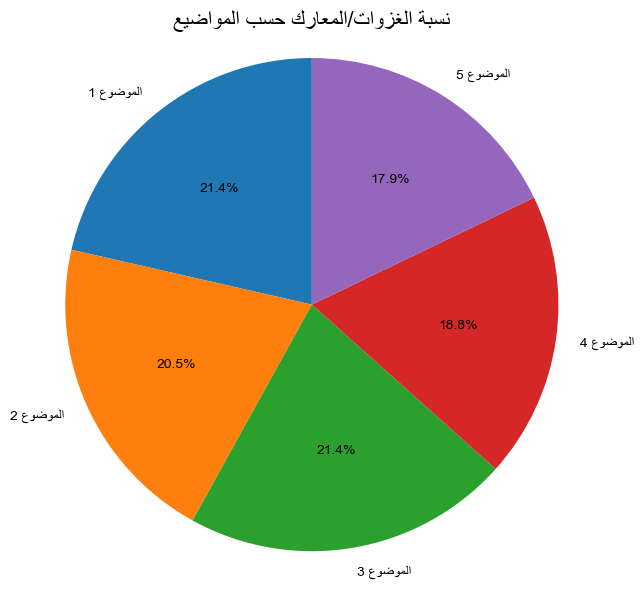

In [217]:
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

# حساب عدد الغزوات في كل موضوع
counts = df['موضوع_LDA'].value_counts().sort_index()

# إنشاء تسميات عربية لكل موضوع باستخدام إعادة التشكيل والعكس
labels = [get_display(arabic_reshaper.reshape(f"الموضوع {i+1}")) for i in counts.index]

# إنشاء الرسم
plt.figure(figsize=(7, 7))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title(get_display(arabic_reshaper.reshape("نسبة الغزوات/المعارك حسب المواضيع")), fontsize=16)
plt.axis('equal')
plt.show()

In [219]:
#####################
#sentiment analysis

In [221]:
!pip install cohere

In [223]:
import pandas as pd
import cohere
import time

# 1. تحميل البيانات
file_path = r"C:\Users\Batoo\Downloads\الغزوات - Sheet1 (1).csv"
df = pd.read_csv(file_path)
df = df[['الاسم', 'القصة', 'أسبابها', 'آثارها']].dropna().reset_index(drop=True)
df = df[:100]  # أول 100 غزوة

# 2. برومبت مخصص لتقليل "انتصار" وتوجيه النموذج بوضوح
def make_prompt(row):
    return f"""أنت نموذج ذكي لتحليل الأحداث التاريخية.

اقرأ النص التالي عن غزوة إسلامية، ثم حدّد نوع الحدث بدقة باستخدام **كلمة واحدة فقط** تعبّر عن طبيعته.

اختر من التصنيفات التالية فقط، واستخدم معناها لتحديد الأنسب للسياق:

التصنيفات ومعانيها:
- انتصار: فوز المسلمين بوضوح على العدو.
- هزيمة: خسارة المسلمين أو تراجعهم في المواجهة.
- خيانة: خرق للعهد أو غدر من طرف آخر.
- تضحية: فداء بالنفس أو أرواح الشهداء لأجل الهدف.
- صبر: تحمّل وصمود المسلمين في موقف صعب دون نتائج واضحة.
- انسحاب: تراجع الجيش أو ترك أرض المعركة دون قتال حاسم.
- مفاوضات: تبادل الكلام أو التواصل بين الطرفين لحل سلمي.
- دفاع: رد العدوان فقط دون الهجوم.
- فتح: دخول المسلمين مدينة أو أرض جديدة **بعد مقاومة أو نتيجة حاسمة**.
- تخطيط: استعداد أو تحركات عسكرية بدون قتال فعلي.
- تهديد: إنذار أو وعيد موجه للعدو.
- دعوة: إرسال رسالة أو عرض الإسلام على العدو.

 تعليمات مهمة:
- لا تكرّر نفس التصنيف في كل الحالات.
- لا تستخدم "انتصار" إلا إذا كان هناك فوز حاسم للمسلمين.
- لا تستخدم "فتح" إلا إذا تم الدخول **بعد مواجهة أو سيطرة واضحة**.
- إذا لم يكن هناك قتال أو نتيجة، استخدم "تخطيط" أو "تمهيد".
- لا تكتب جملة أو شرح، فقط الكلمة المناسبة من القائمة أعلاه.

القصة: {row['القصة']}
الأسباب: {row['أسبابها']}
الآثار: {row['آثارها']}

نوع الحدث:
"""



df["النص"] = df.apply(make_prompt, axis=1)

# 3. ربط مع Cohere
co = cohere.Client("9ilZ419sPFGs7Ec0HDOA8s5SmpllA0f8MGCEs8NF") 

# 4. تحليل كل غزوة
labels = []
for i, prompt in enumerate(df["النص"]):
    print(f" تحليل الغزوة {i+1}/{len(df)} ...")
    response = co.generate(
        model="command-r-plus",
        prompt=prompt,
        max_tokens=10,
        temperature=0.6  # تنويع أكثر مع ضبط النتائج
    )
    text = response.generations[0].text.strip()
    print("التصنيف:", text)
    labels.append(text)
    time.sleep(2)  # مهلة صغيرة بين الطلبات

# 5. حفظ النتائج
df["التصنيف الدلالي"] = labels
df.to_csv("IslamicBattles_part1.csv", index=False, encoding='utf-8-sig')
print("📁 تم الحفظ في ملف: IslamicBattles_part1.csv")

 تحليل الغزوة 1/100 ...
التصنيف: تخطيط
 تحليل الغزوة 2/100 ...
التصنيف: تخطيط
 تحليل الغزوة 3/100 ...
التصنيف: انسحاب
 تحليل الغزوة 4/100 ...
التصنيف: انسحاب
 تحليل الغزوة 5/100 ...
التصنيف: انتصار
 تحليل الغزوة 6/100 ...
التصنيف: فتح
 تحليل الغزوة 7/100 ...
التصنيف: دفاع
 تحليل الغزوة 8/100 ...
التصنيف: فتح
 تحليل الغزوة 9/100 ...
التصنيف: هزيمة
 تحليل الغزوة 10/100 ...
التصنيف: صبر
 تحليل الغزوة 11/100 ...
التصنيف: تخطيط
 تحليل الغزوة 12/100 ...
التصنيف: انسحاب
 تحليل الغزوة 13/100 ...
التصنيف: فتح
 تحليل الغزوة 14/100 ...
التصنيف: تخطيط
 تحليل الغزوة 15/100 ...
التصنيف: تخطيط
 تحليل الغزوة 16/100 ...
التصنيف: تخطيط
 تحليل الغزوة 17/100 ...
التصنيف: صبر
 تحليل الغزوة 18/100 ...
التصنيف: فتح
 تحليل الغزوة 19/100 ...
التصنيف: انتصار
 تحليل الغزوة 20/100 ...
التصنيف: تخطيط
 تحليل الغزوة 21/100 ...
التصنيف: مفاوضات
 تحليل الغزوة 22/100 ...
التصنيف: فتح
 تحليل الغزوة 23/100 ...
التصنيف: انتصار
 تحليل الغزوة 24/100 ...
التصنيف: فتح
 تحليل الغزوة 25/100 ...
التصنيف: صبر
 تحليل الغزوة 26/100

In [225]:
import pandas as pd
import cohere
import time

# 1. تحميل البيانات
file_path = r"C:\Users\Batoo\Downloads\الغزوات - Sheet1 (1).csv"
df = pd.read_csv(file_path)
df = df[['الاسم', 'القصة', 'أسبابها', 'آثارها']].dropna().reset_index(drop=True)
df = df[100:]  # لتحليل الغزوات من رقم 101 إلى النهاية

# 2. برومبت مخصص لتقليل "انتصار" وتوجيه النموذج بوضوح
def make_prompt(row):
    return f"""أنت نموذج ذكي لتحليل الأحداث التاريخية.

اقرأ النص التالي عن غزوة إسلامية، ثم حدّد نوع الحدث بدقة باستخدام **كلمة واحدة فقط** تعبّر عن طبيعته.

اختر من التصنيفات التالية فقط، واستخدم معناها لتحديد الأنسب للسياق:

التصنيفات ومعانيها:
- انتصار: فوز المسلمين بوضوح على العدو.
- هزيمة: خسارة المسلمين أو تراجعهم في المواجهة.
- خيانة: خرق للعهد أو غدر من طرف آخر.
- تضحية: فداء بالنفس أو أرواح الشهداء لأجل الهدف.
- صبر: تحمّل وصمود المسلمين في موقف صعب دون نتائج واضحة.
- انسحاب: تراجع الجيش أو ترك أرض المعركة دون قتال حاسم.
- مفاوضات: تبادل الكلام أو التواصل بين الطرفين لحل سلمي.
- دفاع: رد العدوان فقط دون الهجوم.
- فتح: دخول المسلمين مدينة أو أرض جديدة **بعد مقاومة أو نتيجة حاسمة**.
- تخطيط: استعداد أو تحركات عسكرية بدون قتال فعلي.
- تهديد: إنذار أو وعيد موجه للعدو.
- دعوة: إرسال رسالة أو عرض الإسلام على العدو.

 تعليمات مهمة:
- لا تكرّر نفس التصنيف في كل الحالات.
- لا تستخدم "انتصار" إلا إذا كان هناك فوز حاسم للمسلمين.
- لا تستخدم "فتح" إلا إذا تم الدخول **بعد مواجهة أو سيطرة واضحة**.
- إذا لم يكن هناك قتال أو نتيجة، استخدم "تخطيط" أو "تمهيد".
- لا تكتب جملة أو شرح، فقط الكلمة المناسبة من القائمة أعلاه.

القصة: {row['القصة']}
الأسباب: {row['أسبابها']}
الآثار: {row['آثارها']}

نوع الحدث:
"""



df["النص"] = df.apply(make_prompt, axis=1)

# 3. ربط مع Cohere
co = cohere.Client("fgFIgshk4pz5r4pOnx5GyaWw0LFmNZroaLqBGwod") 

# 4. تحليل كل غزوة
labels = []
for i, prompt in enumerate(df["النص"]):
    print(f" تحليل الغزوة {i+1}/{len(df)} ...")
    response = co.generate(
        model="command-r-plus",
        prompt=prompt,
        max_tokens=10,
        temperature=0.6  # تنويع أكثر مع ضبط النتائج
    )
    text = response.generations[0].text.strip()
    print("التصنيف:", text)
    labels.append(text)
    time.sleep(2)  # مهلة صغيرة بين الطلبات

# 5. حفظ النتائج
df["التصنيف الدلالي"] = labels
df.to_csv("IslamicBattles_part2.csv", index=False, encoding='utf-8-sig')
print("📁 تم الحفظ في ملف: IslamicBattles_part2.csv")

 تحليل الغزوة 1/12 ...
التصنيف: فتح
 تحليل الغزوة 2/12 ...
التصنيف: فتح
 تحليل الغزوة 3/12 ...
التصنيف: انسحاب
 تحليل الغزوة 4/12 ...
التصنيف: فتح
 تحليل الغزوة 5/12 ...
التصنيف: فتح
 تحليل الغزوة 6/12 ...
التصنيف: انتصار
 تحليل الغزوة 7/12 ...
التصنيف: "دفاع"
 تحليل الغزوة 8/12 ...
التصنيف: هزيمة
 تحليل الغزوة 9/12 ...
التصنيف: انتصار
 تحليل الغزوة 10/12 ...
التصنيف: صبر
 تحليل الغزوة 11/12 ...
التصنيف: انتصار
 تحليل الغزوة 12/12 ...
التصنيف: هزيمة
📁 تم الحفظ في ملف: IslamicBattles_part2.csv


In [227]:
df1 = pd.read_csv("IslamicBattles_part1.csv")
df2 = pd.read_csv("IslamicBattles_part2.csv")

merged = pd.concat([df1, df2], ignore_index=True)
merged.to_csv("IslamicBattles_full.csv", index=False, encoding='utf-8-sig')

print("📁 تم دمج الملفين في: IslamicBattles_full.csv")

📁 تم دمج الملفين في: IslamicBattles_full.csv


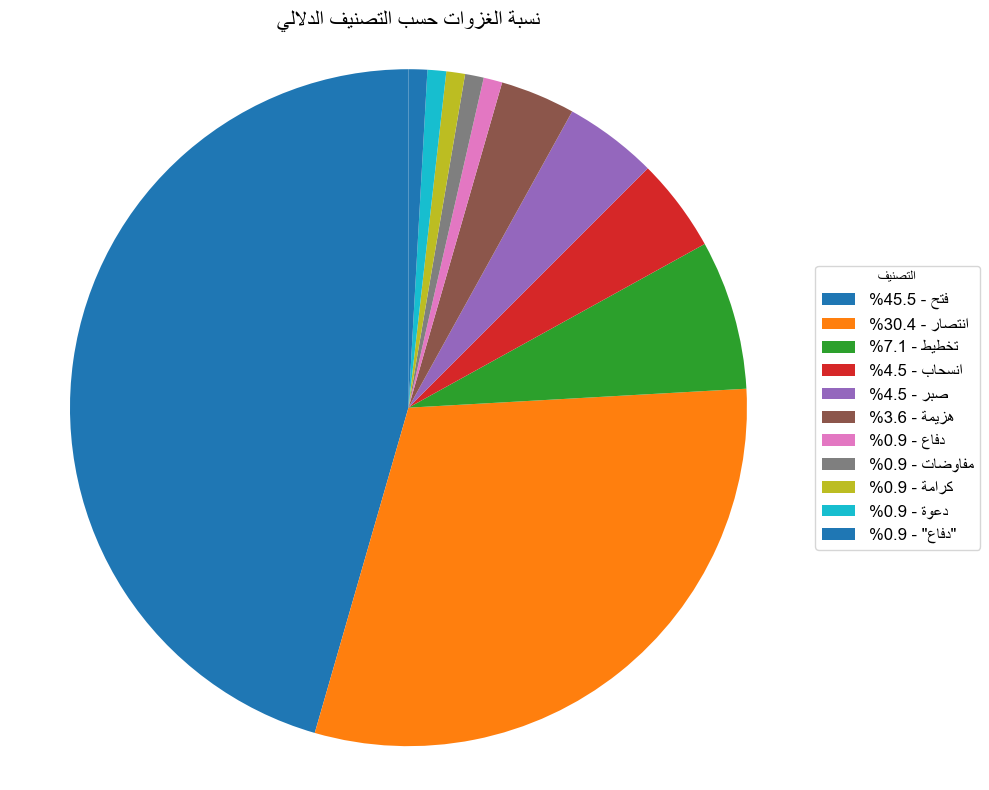

In [229]:
import pandas as pd
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

# 1. تحميل البيانات
df = pd.read_csv("IslamicBattles_full.csv")

# 2. حساب عدد الغزوات لكل تصنيف دلالي
counts = df['التصنيف الدلالي'].value_counts()
percentages = counts / counts.sum() * 100

# 3. تجهيز التسميات مع النسبة
labels = [
    get_display(arabic_reshaper.reshape(f"{label} - {percentages[label]:.1f}%"))
    for label in counts.index
]

# 4. إنشاء الرسم
plt.figure(figsize=(10, 8))
wedges, _ = plt.pie(  # ← تم التعديل هنا
    counts,
    startangle=90,
    textprops={'fontsize': 12}
)

# 5. عرض التصنيفات + النسب في مربع جانبي
plt.legend(
    wedges,
    labels,
    title=get_display(arabic_reshaper.reshape("التصنيف")),
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=12
)

plt.title(get_display(arabic_reshaper.reshape("نسبة الغزوات حسب التصنيف الدلالي")), fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
#################################
#NER

In [277]:
!pip install -U transformers

In [279]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("token-classification", model="boda/ANER")

In [281]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("boda/ANER")
model = AutoModelForTokenClassification.from_pretrained("boda/ANER")

In [285]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r"C:\Users\Batoo\Downloads\الغزوات - Sheet1 (1).csv", encoding='utf-8')

# Display the first few rows to understand the structure
print(df.head(5))

                  الاسم نوع الحدث فتح التاريخ         القائد           عهد  \
0  غزوة ودان أو الأبواء      غزوة   -    2 هـ   النبي محمد ﷺ  النبي محمد ﷺ   
1             غزوة بواط      غزوة   -    2 هـ   النبي محمد ﷺ  النبي محمد ﷺ   
2            غزوة سفوان      غزوة   -    2 هـ   النبي محمد ﷺ  النبي محمد ﷺ   
3       غزوة ذي العشيرة      غزوة   -    2 هـ   النبي محمد ﷺ  النبي محمد ﷺ   
4              غزوة بدر      غزوة   -    2 هـ   النبي محمد ﷺ  النبي محمد ﷺ   

                        الموقع عدد المسلمين          الأعداء عدد الأعداء  \
0                  منطقة ودّان           70  قريش (بني ضمرة)    غير محدد   
1                   منطقة بواط          200             قريش         100   
2       وادي سفوان في قرية بدر           70             قريش    غير محدد   
3             منطقة ذو العشيرة    150 - 200             قريش    غير محدد   
4  منطقة بدر بين مكة و المدينة          313             قريش  900 - 1000   

         قائد الأعداء                                              القصة  

In [287]:
import pandas as pd
from collections import defaultdict
from transformers import pipeline
import re

# 1. Initialize the NER pipeline correctly
ner_pipeline = pipeline(
    "ner",
    model="boda/ANER",
    tokenizer="boda/ANER",
    aggregation_strategy="simple",
)

In [289]:
# 2. Text cleaning function
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    # Remove tashkeel (Arabic diacritics)
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
    # Normalize Arabic characters
    text = re.sub(r'[إأآا]', 'ا', text)
    text = re.sub(r'[ى]', 'ي', text)
    text = re.sub(r'[ؤئ]', 'ء', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [291]:
# 3. Entity extraction function
def extract_entities(text):
    if not text or not isinstance(text, str):
        return []

    try:
        # Process text through NER pipeline
        results = ner_pipeline(text[:512])  # Limit to first 512 characters
        return results
    except Exception as e:
        print(f"Error processing text: {str(e)}")
        return []

In [293]:

# 4. Categorization function
def categorize_entities(ner_results):
    categories = {
        'PER': [],  # Persons
        'LOC': [],  # Locations
        'ORG': [],  # Organizations
        'MISC': []  # Miscellaneous
    }

    for entity in ner_results:
        group = entity.get('entity_group', '').strip()
        word = entity.get('word', '')

        if not word:
            continue

        if 'شخص' in group:
            categories['PER'].append(word)
        elif 'مركز' in group or 'ولاية' in group:
            categories['LOC'].append(word)
        elif 'مجموعة' in group:
            categories['ORG'].append(word)
        else:
            categories['MISC'].append(word)

    # Deduplicate
    for key in categories:
        categories[key] = list(set(categories[key]))

    return categories

In [295]:
# 5. Process your dataframe
def process_dataframe(df, text_column='القصة'):
    # Clean text
    df['clean_text'] = df[text_column].apply(clean_text)

    # Extract entities
    df['ner_results'] = df['clean_text'].apply(extract_entities)

    # Categorize entities
    df['entities'] = df['ner_results'].apply(categorize_entities)

    # Create separate columns for each entity type
    entity_types = ['PER', 'LOC', 'ORG', 'MISC']
    for etype in entity_types:
        df[f'entities_{etype}'] = df['entities'].apply(lambda x: x.get(etype, []))

    return df

In [297]:
# 6. Load your data
df = pd.read_csv(r"C:\Users\Batoo\Downloads\الغزوات - Sheet1 (1).csv", encoding='utf-8')

# 7. Process the dataframe
df_processed = process_dataframe(df)

# 8. Analyze results
def print_top_entities(df, entity_type):
    print(f"\nTop {entity_type} entities:")
    all_entities = []
    for ents in df[f'entities_{entity_type}']:
        all_entities.extend(ents)
    print(pd.Series(all_entities).value_counts().head(10))

print_top_entities(df_processed, 'PER')
print_top_entities(df_processed, 'LOC')
print_top_entities(df_processed, 'ORG')
print_top_entities(df_processed, 'MISC')


Top PER entities:
عمر بن الخطاب      6
محمد               4
عمر                3
عمار بن ياسر       2
سعد بن ابي وقاص    2
علي بن ابي طالب    2
بن                 2
هاشم بن عتبة       2
علي                2
##د                1
Name: count, dtype: int64

Top LOC entities:
المدينة            18
دمشق               10
المداءن             6
فارس                6
الحيرة              6
المدينة المنورة     5
القادسية            5
بدر                 5
خراسان              4
مكة                 4
Name: count, dtype: int64

Top ORG entities:
المسلمون      66
المسلمين      59
الفرس         25
قريش          10
الروم         10
للمسلمين       8
العرب          6
البيزنطيين     4
اليهود         3
البيزنطيون     3
Name: count, dtype: int64

Top MISC entities:
خالد بن الوليد         32
الشام                  19
خالد                   18
العراق                 15
عمر بن الخطاب          14
عثمان بن عفان           9
ابو عبيدة بن الجراح     7
ابي بكر الصديق          6
الفرات                  6
يزدجرد الثا

In [299]:
# 9. Save results
df_processed.to_csv("processed_battles_with_ner.csv", index=False, encoding='utf-8-sig')

# 10. Show sample results
print("\nSample processed rows:")
print(df_processed[['الاسم', 'entities_PER', 'entities_LOC', 'entities_ORG']].head(3))


Sample processed rows:
                  الاسم                         entities_PER     entities_LOC  \
0  غزوة ودان أو الأبواء  [عمرو بن مخشي الضمري, سعد بن عبادة]  [الابواء, ودان]   
1             غزوة بواط      [امية بن خلف الجمحي, رسول الله]     [بواط, رضوي]   
2            غزوة سفوان                                   []   [المدينة, بدر]   

                            entities_ORG  
0  [لقريش, بني ضمرة, المسلمين وبني ضمرة]  
1                [لقريش, المسلمون, قريش]  
2                                     []  


In [301]:
def unify_entities(entity_list):
    replacements = {
        'المدينة المنورة': 'المدينة',
        'المسلمين': 'المسلمون',
        'عمر': 'عمر بن الخطاب',
        'خالد': 'خالد بن الوليد'
    }
    return [replacements.get(e, e) for e in entity_list]

df['entities_PER'] = df['entities_PER'].apply(unify_entities)
df['entities_LOC'] = df['entities_LOC'].apply(unify_entities)
df['entities_ORG'] = df['entities_ORG'].apply(unify_entities)

In [307]:
!pip install arabic-reshaper
!pip install python-bidi

In [311]:
from PIL import ImageFont
import os

In [317]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import re
from collections import defaultdict
from transformers import pipeline
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from arabic_reshaper import reshape
from bidi.algorithm import get_display

# Initialize NER pipeline
ner_pipeline = pipeline(
    "ner",
    model="boda/ANER",
    tokenizer="boda/ANER",
    aggregation_strategy="simple",
)

# Text cleaning and normalization
def clean_arabic_text(text):
    if pd.isna(text):
        return ""

    text = str(text)

    # Remove diacritics
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)

    # Normalize Arabic characters
    text = re.sub(r'[إأآا]', 'ا', text)
    text = re.sub(r'[ى]', 'ي', text)
    text = re.sub(r'[ؤئ]', 'ء', text)

    # Remove honorifics and religious phrases
    text = re.sub(r'رحمه الله|رضي الله عنه|عليه السلام|ﷺ', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Entity unification mapping
entity_unification = {
    'لقريش': 'قريش',
    'المسلمون': 'المسلمين',
    'للمسلمين':'المسلمين',
    '##يدة وعلي': 'عبيدة وعلي',
    'وادي سفوان': 'سفوان',
    'الرسول': 'محمد',
    'رسول الله': 'محمد'
}

def unify_entities(entity_list):
    return [entity_unification.get(e, e) for e in entity_list if not e.startswith('##')]

# Enhanced entity classification
def refine_entity_classification(entity):
    word = entity['word']
    entity_group = entity['entity_group'].strip()

    # Person refinements
    if 'بن' in word and entity_group in ['شرطة', 'سياسي', ' شخص ']:
        return {**entity, 'entity_group': ' شخص ديني '}

    # Location refinements
    elif 'وادي' in word or 'بدر' in word:
        return {**entity, 'entity_group': ' مركز سكني '}

    # Tribe/Group refinements
    elif entity_group == ' مجموعة ':
        if 'بني' in word or 'بنو' in word:
            return {**entity, 'entity_group': ' قبيلة '}
        elif word in ['قريش', 'المسلمين']:
            return {**entity, 'entity_group': ' جماعة '}

    return entity

# Process NER results
def process_ner_results(ner_results):
    if not isinstance(ner_results, list):
        return []

    processed = []
    for entity in ner_results:
        # Skip low-confidence entities (threshold = 0.7)
        if entity['score'] < 0.7:
            continue

        refined = refine_entity_classification(entity)
        processed.append(refined)

    return processed

# Categorize entities
def categorize_entities(ner_results):
    categories = {
        'PER': [],  # Persons
        'LOC': [],  # Locations
        'ORG': [],  # Organizations/Tribes
        'MISC': [], # Miscellaneous
        'DATES': [] # Dates
    }

    for entity in ner_results:
        group = entity['entity_group'].strip()
        word = entity['word']

        if 'شخص' in group:
            categories['PER'].append(word)
        elif 'مركز' in group or 'ولاية' in group or 'وادي' in word:
            categories['LOC'].append(word)
        elif 'قبيلة' in group or 'جماعة' in group or 'مجموعة' in group:
            categories['ORG'].append(word)
        else:
            categories['MISC'].append(word)

    # Unify and clean entities
    for key in categories:
        categories[key] = unify_entities(categories[key])
        categories[key] = list(set(categories[key]))  # Remove duplicates

    return categories

# Main processing function
def process_dataframe(df, text_column='القصة'):
    print("Cleaning text...")
    df['clean_text'] = df[text_column].apply(clean_arabic_text)

    print("Running NER...")
    df['ner_results'] = [ner_pipeline(text[:512]) for text in tqdm(df['clean_text'])]

    print("Processing entities...")
    df['ner_results'] = df['ner_results'].apply(process_ner_results)
    df['entities'] = df['ner_results'].apply(categorize_entities)

    # Create separate columns for each entity type
    entity_types = ['PER', 'LOC', 'ORG', 'MISC']
    for etype in entity_types:
        df[f'entities_{etype}'] = df['entities'].apply(lambda x: x.get(etype, []))

    return df

# Analysis functions
def generate_entity_stats(df, entity_type):
    all_entities = []
    for ents in df[f'entities_{entity_type}']:
        all_entities.extend(ents)

    return pd.Series(all_entities).value_counts()

def visualize_entities(entity_series, title):
    # Combine all entities into a single string
    text = ' '.join(entity_series.index)

    # Reshape and apply bidi for proper Arabic rendering
    reshaped_text = reshape(text)
    bidi_text = get_display(reshaped_text)

    # Reshape the title
    reshaped_title = reshape(title)
    bidi_title = get_display(reshaped_title)

    # Try to find or download an Arabic font
    font_path = get_arabic_font()

    # Generate word cloud
    wordcloud = WordCloud(
        font_path=font_path,
        width=800,
        height=400,
        background_color='white',
        collocations=False,
        font_step=1  # Important for Arabic
    ).generate(bidi_text)

    # Display
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(bidi_title, fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def get_arabic_font():
    """Helper function to find or download an Arabic font"""
    # Check common system locations first
    system_fonts = [
        '/usr/share/fonts/truetype/noto/NotoNaskhArabic-Regular.ttf',  # Ubuntu
        '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf',  # Fallback
        '/Library/Fonts/Arial Unicode.ttf',  # MacOS
        'C:/Windows/Fonts/arial.ttf'  # Windows
    ]

    for font in system_fonts:
        if os.path.exists(font):
            return font

    # If no system font found, download Noto Sans Arabic
    try:
        if not os.path.exists('NotoSansArabic'):
            import requests
            import zipfile
            import io

            print("Downloading Arabic font...")
            url = "https://fonts.google.com/download?family=Noto%20Sans%20Arabic"
            r = requests.get(url)
            z = zipfile.ZipFile(io.BytesIO(r.content))
            z.extractall("NotoSansArabic")

        return "NotoSansArabic/NotoSansArabic-Regular.ttf"
    except:
        print("Warning: Could not download Arabic font. Trying default font.")
        return None  # Will use WordCloud's default

def extract_battle_relations(df):
    relations = defaultdict(int)
    for _, row in df.iterrows():
        persons = row['entities_PER']
        locations = row['entities_LOC']
        for p in persons:
            for l in locations:
                relations[(p, l)] += 1
    return relations

# Load data
print("Loading data...")
df = pd.read_csv(r"C:\Users\Batoo\Downloads\الغزوات - Sheet1 (1).csv", encoding='utf-8')

# Process data
df_processed = process_dataframe(df)

# Analysis
print("\nTop Persons:")
top_per = generate_entity_stats(df_processed, 'PER').head(10)
print(top_per)

print("\nTop Locations:")
top_loc = generate_entity_stats(df_processed, 'LOC').head(10)
print(top_loc)

print("\nTop Organizations/Tribes:")
top_org = generate_entity_stats(df_processed, 'ORG').head(10)
print(top_org)


# Battle relations analysis
battle_relations = extract_battle_relations(df_processed)
print("\nTop Person-Location Relations:")
for (person, location), count in sorted(battle_relations.items(), key=lambda x: -x[1])[:5]:
    print(f"{person} ↔ {location}: {count} مرات")

# Enhanced battle analysis
def analyze_battle(row):
    return {
        'الغزوة': row['الاسم'],
        'القادة المسلمون': [p for p in row['entities_PER'] if 'بن' in p],
        'القادة الآخرون': [p for p in row['entities_PER'] if 'بن' not in p],
        'المواقع': row['entities_LOC'],
        'القبائل المشاركة': [t for t in row['entities_ORG'] if 'بني' in t or 'بنو' in t],
        'ملاحظات': row['entities_MISC']
    }

battle_analyses = df_processed.apply(analyze_battle, axis=1)


# Save results
df_processed.to_csv("processed_battles_with_ner.csv", index=False, encoding='utf-8-sig')
print("\nProcessing complete! Results saved to processed_battles_with_ner.csv")

Loading data...
Cleaning text...
Running NER...


100%|████████████████████████████████████████████████████████████████████████████████| 115/115 [00:38<00:00,  2.97it/s]

Processing entities...

Top Persons:
خالد بن الوليد         30
عمر بن الخطاب          20
عثمان بن عفان           9
محمد                    7
علي بن ابي طالب         7
ابو عبيدة بن الجراح     6
عمرو بن العاص           4
معاوية بن ابي سفيان     4
الاحنف بن قيس           4
سعد بن ابي وقاص         4
Name: count, dtype: int64

Top Locations:
المدينة            17
دمشق               10
فارس                6
الحيرة              6
المداءن             6
المدينة المنورة     5
القادسية            4
خراسان              4
مكة                 4
قب                  3
Name: count, dtype: int64

Top Organizations/Tribes:
المسلمين            88
الفرس               26
قريش                12
الروم               10
العرب                5
البيزنطيين           4
اليهود               3
الروم البيزنطيين     3
البيزنطيون           3
العرب النصاري        3
Name: count, dtype: int64

Top Person-Location Relations:
خالد بن الوليد ↔ الحيرة: 5 مرات
خالد بن الوليد ↔ دمشق: 5 مرات
عمر بن الخطاب ↔ فارس: 5 مرات
خالد بن ا

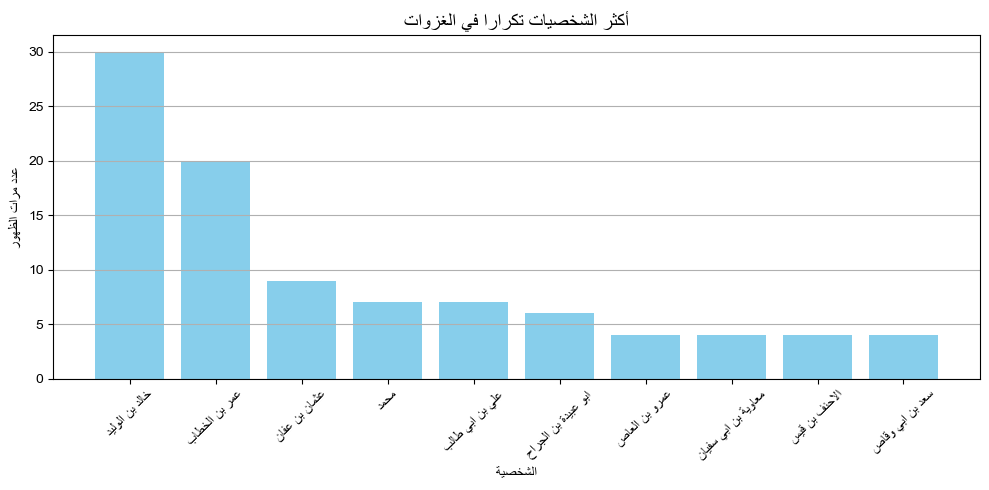

In [325]:
import matplotlib.pyplot as plt
from arabic_reshaper import reshape
from bidi.algorithm import get_display

# استخراج أكثر الشخصيات تكرارًا
top_persons = df_processed['entities_PER'].explode().value_counts().head(10)

# ترتيب الأسماء بالعربي
labels = [get_display(reshape(label)) for label in top_persons.index]

# رسم المخطط
plt.figure(figsize=(10,5))
plt.bar(labels, top_persons.values, color='skyblue')
plt.title(get_display(reshape("أكثر الشخصيات تكرارًا في الغزوات")), fontsize=14)
plt.xlabel(get_display(reshape("الشخصية")))
plt.ylabel(get_display(reshape("عدد مرات الظهور")))
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

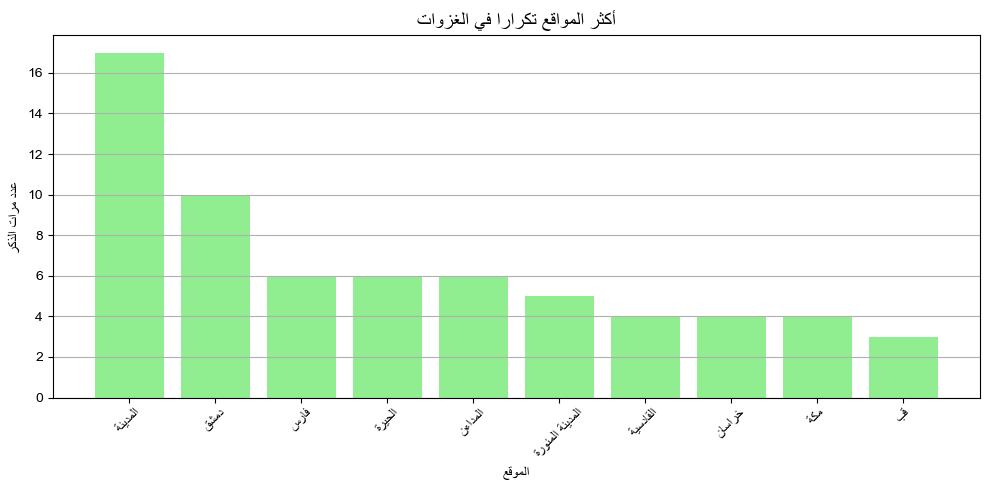

In [327]:
top_locations = df_processed['entities_LOC'].explode().value_counts().head(10)
labels = [get_display(reshape(label)) for label in top_locations.index]

plt.figure(figsize=(10,5))
plt.bar(labels, top_locations.values, color='lightgreen')
plt.title(get_display(reshape("أكثر المواقع تكرارًا في الغزوات")), fontsize=14)
plt.xlabel(get_display(reshape("الموقع")))
plt.ylabel(get_display(reshape("عدد مرات الذكر")))
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

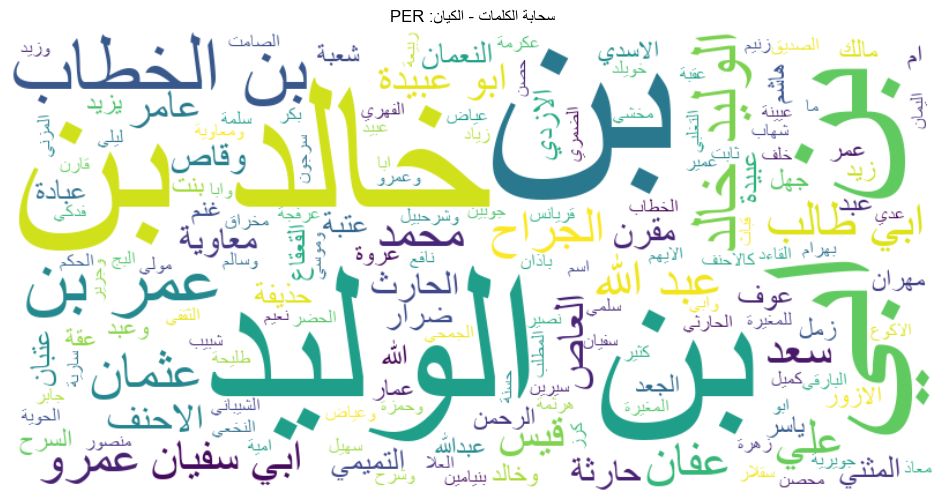

In [329]:
from wordcloud import WordCloud

# تغيير هذا المتغير حسب الكيان المرغوب: PER / LOC / ORG
entity_type = 'PER'

# تجهيز النص
text = ' '.join(df_processed[f'entities_{entity_type}'].explode().dropna())
reshaped_text = reshape(text)
bidi_text = get_display(reshaped_text)

# رسم السحابة
wordcloud = WordCloud(
    font_path='C:/Windows/Fonts/arial.ttf',
    width=800,
    height=400,
    background_color='white'
).generate(bidi_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(get_display(reshape(f"سحابة الكلمات - الكيان: {entity_type}")))
plt.show()

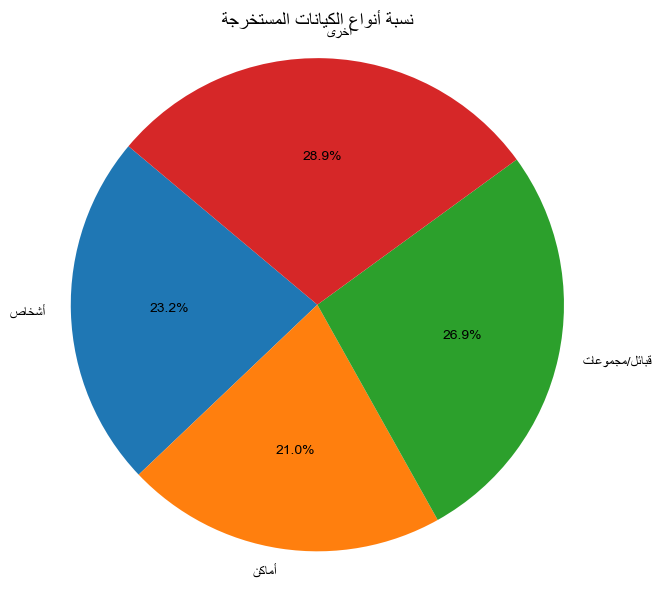

In [333]:
entity_counts = {
    'أشخاص': df_processed['entities_PER'].explode().count(),
    'أماكن': df_processed['entities_LOC'].explode().count(),
    'قبائل/مجموعات': df_processed['entities_ORG'].explode().count(),
    'أخرى': df_processed['entities_MISC'].explode().count()
}

labels = [get_display(reshape(label)) for label in entity_counts.keys()]

plt.figure(figsize=(7,7))
plt.pie(entity_counts.values(), labels=labels, autopct='%1.1f%%', startangle=140)
plt.title(get_display(reshape("نسبة أنواع الكيانات المستخرجة")), fontsize=14)
plt.axis('equal')
plt.show()

In [353]:
import pandas as pd
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from arabic_reshaper import reshape

# تلخيص الغزوات حسب العهد
def summarize_by_era(df):
    summaries = []

    if 'عهد' not in df.columns:
        raise ValueError("العمود 'عهد' غير موجود في البيانات!")

    for era in df['عهد'].dropna().unique():
        subset = df[df['عهد'] == era]
        total_battles = len(subset)
        all_persons = sum(subset['entities_PER'], [])
        all_locations = sum(subset['entities_LOC'], [])

        top_person = pd.Series(all_persons).value_counts().idxmax() if all_persons else 'غير محدد'
        top_location = pd.Series(all_locations).value_counts().idxmax() if all_locations else 'غير محدد'

        summary = {
            'العهد': era,
            'عدد الغزوات': total_battles,
            'عدد القادة الفريدين': len(set(all_persons)),
            'عدد المواقع الفريدة': len(set(all_locations)),
            'أشهر قائد': top_person,
            'أشهر موقع': top_location
        }

        summaries.append(summary)

    return pd.DataFrame(summaries)

# تنفيذ التلخيص
era_summary_df = summarize_by_era(df_processed)

from arabic_reshaper import reshape

# عرض النتائج
print("📊 ملخص الغزوات حسب العهد:\n")

for _, row in era_summary_df.iterrows():
    print("-" * 50)
    print(reshape(f" العهد: {row['العهد']}"))
    print(reshape(f" عدد الغزوات: {row['عدد الغزوات']}"))
    print(reshape(f" عدد القادة الفريدين: {row['عدد القادة الفريدين']}"))
    print(reshape(f" عدد المواقع الفريدة: {row['عدد المواقع الفريدة']}"))
    print(reshape(f" أشهر قائد: {row['أشهر قائد']}"))
    print(reshape(f" أشهر موقع: {row['أشهر موقع']}"))


📊 ملخص الغزوات حسب العهد:

--------------------------------------------------
 ﺍﻟﻌﻬﺪ: ﺍﻟﻨﺒﻲ ﻣﺤﻤﺪ ﷺ
 ﻋﺪﺩ ﺍﻟﻐﺰﻭﺍﺕ: 29
 ﻋﺪﺩ ﺍﻟﻘﺎﺩﺓ ﺍﻟﻔﺮﻳﺪﻳﻦ: 19
 ﻋﺪﺩ ﺍﻟﻤﻮﺍﻗﻊ ﺍﻟﻔﺮﻳﺪﺓ: 20
 ﺃﺷﻬﺮ ﻗﺎﺋﺪ: ﻣﺤﻤﺪ
 ﺃﺷﻬﺮ ﻣﻮﻗﻊ: ﺍﻟﻤﺪﻳﻨﺔ
--------------------------------------------------
 ﺍﻟﻌﻬﺪ: ﺃﺑﻮ ﺑﻜﺮ ﺍﻟﺼﺪﻳﻖ ﺭﺿﻲ ﷲ ﻋﻨﻪ
 ﻋﺪﺩ ﺍﻟﻐﺰﻭﺍﺕ: 29
 ﻋﺪﺩ ﺍﻟﻘﺎﺩﺓ ﺍﻟﻔﺮﻳﺪﻳﻦ: 29
 ﻋﺪﺩ ﺍﻟﻤﻮﺍﻗﻊ ﺍﻟﻔﺮﻳﺪﺓ: 30
 ﺃﺷﻬﺮ ﻗﺎﺋﺪ: ﺧﺎﻟﺪ ﺑﻦ ﺍﻟﻮﻟﻴﺪ
 ﺃﺷﻬﺮ ﻣﻮﻗﻊ: ﺍﻟﺤﻴﺮﺓ
--------------------------------------------------
 ﺍﻟﻌﻬﺪ: ﻋﻤﺮ ﺑﻦ ﺍﻟﺨﻄﺎﺏ ﺭﺿﻲ ﷲ ﻋﻨﻪ
 ﻋﺪﺩ ﺍﻟﻐﺰﻭﺍﺕ: 38
 ﻋﺪﺩ ﺍﻟﻘﺎﺩﺓ ﺍﻟﻔﺮﻳﺪﻳﻦ: 41
 ﻋﺪﺩ ﺍﻟﻤﻮﺍﻗﻊ ﺍﻟﻔﺮﻳﺪﺓ: 48
 ﺃﺷﻬﺮ ﻗﺎﺋﺪ: ﻋﻤﺮ ﺑﻦ ﺍﻟﺨﻄﺎﺏ
 ﺃﺷﻬﺮ ﻣﻮﻗﻊ: ﻓﺎﺭﺱ
--------------------------------------------------
 ﺍﻟﻌﻬﺪ: ﻋﺜﻤﺎﻥ ﺑﻦ ﻋﻔﺎﻥ ﺭﺿﻲ ﷲ ﻋﻨﻪ
 ﻋﺪﺩ ﺍﻟﻐﺰﻭﺍﺕ: 13
 ﻋﺪﺩ ﺍﻟﻘﺎﺩﺓ ﺍﻟﻔﺮﻳﺪﻳﻦ: 15
 ﻋﺪﺩ ﺍﻟﻤﻮﺍﻗﻊ ﺍﻟﻔﺮﻳﺪﺓ: 20
 ﺃﺷﻬﺮ ﻗﺎﺋﺪ: ﻋﺜﻤﺎﻥ ﺑﻦ ﻋﻔﺎﻥ
 ﺃﺷﻬﺮ ﻣﻮﻗﻊ: ﺧﺮﺍﺳﺎﻥ
--------------------------------------------------
 ﺍﻟﻌﻬﺪ: ﻋﻠﻲ ﺑﻦ ﺃﺑﻲ ﻃﺎﻟﺐ ﺭﺿﻲ ﷲ ﻋﻨﻪ
 ﻋﺪﺩ ﺍﻟﻐﺰﻭﺍﺕ: 6
 ﻋﺪﺩ ﺍﻟﻘﺎﺩﺓ ﺍﻟﻔﺮﻳﺪﻳﻦ: 14
 ﻋﺪﺩ ﺍﻟﻤﻮﺍﻗﻊ ﺍﻟﻔﺮﻳﺪﺓ: 5
 ﺃﺷﻬﺮ ﻗﺎﺋﺪ: ﻋﻠﻲ ﺑﻦ ﺍﺑﻲ ﻃﺎﻟﺐ
 ﺃﺷﻬﺮ ﻣﻮﻗﻊ: ﻫﻴﺖ


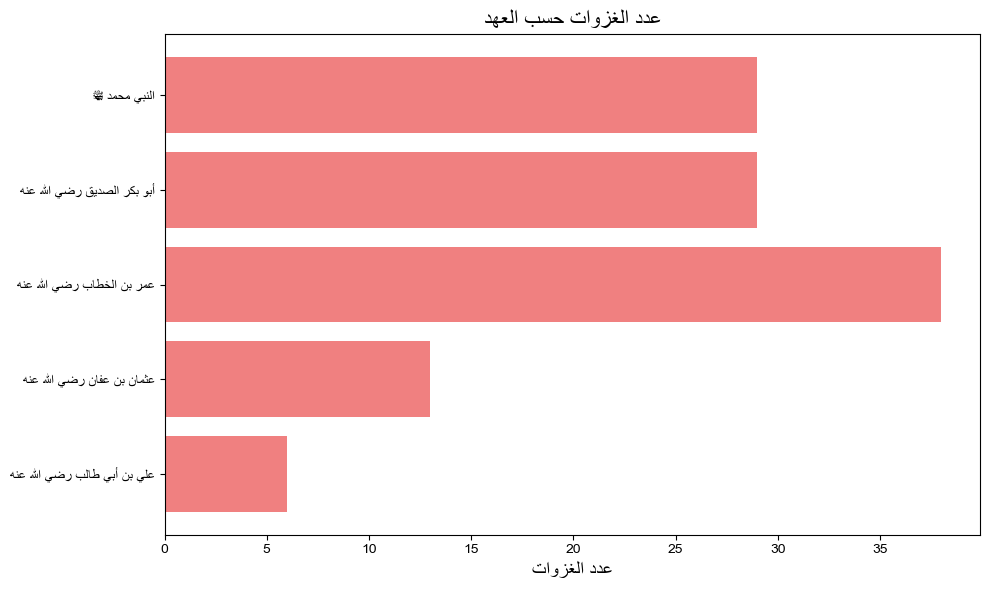

In [359]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from arabic_reshaper import reshape
from bidi.algorithm import get_display

# إعداد الخط المناسب للغة العربية (تأكدي إنه مثبت في النظام)
rcParams['font.family'] = 'Arial'  # جربي 'Cairo', 'Amiri', أو 'Tahoma' إذا ما ضبط

# إعادة تشكيل النصوص بالعربي + دعم اتجاه الكتابة من اليمين لليسار
def prepare_arabic_text(text):
    return get_display(reshape(text))

# تجهيز البيانات
labels = [prepare_arabic_text(str(era)) for era in era_summary_df['العهد']]
values = era_summary_df['عدد الغزوات']

# رسم الرسم البياني
plt.figure(figsize=(10, 6))
plt.barh(labels, values, color='lightcoral')

# إعداد النصوص بالعربي
plt.xlabel(prepare_arabic_text('عدد الغزوات'), fontsize=14)
plt.title(prepare_arabic_text('عدد الغزوات حسب العهد'), fontsize=16)

# عكس الترتيب حتى تظهر الأحدث في الأعلى
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()